### Import various Libraries 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Imports from Skikit Learn
from sklearn.model_selection import train_test_split
# Min Max Scaling Function
from sklearn.preprocessing import MinMaxScaler
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
# Find the R2Score 
from sklearn.metrics import r2_score,mean_squared_error
# Import Statistical Moldel for Statistical Linear Regression
import statsmodels.api as sm  
# Calculate the VIFs for the new model
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from datetime import datetime

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
## MinMax Enable for Sale-Price
EnMinMaxScaleForY = 1;
## How many Features to consider as RFE Features
nRFEFeatures = 600;
ForceLasRidScale = 0;
RegularizationScale = 2;
OutlierTreatMent = 1 ; #1 -> Yes , #0 -> No   
OutlierTreatMentPerc = 0.05;  #0.05,0.035,0.025..
EnableLogTransForTarget = 1;  # Enable Log Translation of the Output
ElimCollinearColAbv60 = 0; # Eliminate Columns above 60 perc collinearity
ElimCollinearColAbv70 = 1; # Eliminate Columns above 70 perc collinearity
Prec=4

##
enOneHotEncServCatCol = 1; ## Consider the Monthly,Sachet as Categorial Column and do One-hot Encoding of the same.

## 
enableHighPrcPlot = 0;

## Dynamic Configurations
-----
- Enabling Min-MaX Scaling (=1 MinMaX Scaling , =0 No Scaling)
- Choice to treat 'yr' for one hot encoding (EnDummyEncForYr)
- Setting up the # of Features for RFE
- Feature selection is done as per nRFEFeatures=13 for EnMinMaxScale=1 and nRFEFeatures=21 with EnMinMaxScale=0
- For other nRFEFeatures # The selection/droping of features should be iteratively performed

<a id="1.1"> SET CONFIGURATIONS BELOW  </a>

In [16]:
## MinMax Enable
EnMinMaxScale = 1;
EnDummyEncForYr = 1;
Prec = 4
## How many Features to consider as RFE Features
nRFEFeatures = 14;
if (EnMinMaxScale==0):
    Prec = 1
    nRFEFeatures = 21; ## This is chosen till RFE selects 'temp' Feature .
    

### Exploratory Data Analysis

- Read both training and test-data
- Identify Categorical Columns and Numerical Columns
- Perform the Data-cleaning and Missing Value of Categorical Columns
     - Drop Columns with >50% Null Values
     - Drop Columns with only one Value as it doesnt convey any information
     - For surviving date columns since the ony date is changing and not month and year parsing is done to retain only date
     - Data imputation with Median
     - Change them to categorical grouped day (Configurable in # of days)
     - One-hot encoding.
     - Convert Features less than 32 value_counts  to Categorical Columns (Optional) followed by one hot encoding
- Perform the Data-cleaning and Missing Value of Numerical Columns
    - Finding Nan Columns and appropriate imputaion or dropping.
    - Outlier Treatment for Features
- Exploratory Data Analysis
    - Univariate
    - BiVariate
    - MultiVariate 
    
Note : The provided test-data in test.csv also goes through feature Engineering and Column conversions and imputations.


In [17]:
# Importing day.csv (Vehicle Demand DataSet)
teleTrain = pd.read_csv('train.csv')
teleTest = pd.read_csv('test.csv')
solutionRef = pd.read_csv('solution.csv')

In [18]:
teleTrain.shape

(69999, 172)

In [19]:
teleTrain.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


- Merge the solution with associated test-data  will be useful in analysing prediction KPI

In [20]:
solutionRef.shape
teleTest = pd.merge(teleTest, solutionRef, on='id', how='inner')
teleTest.shape


(30000, 172)

In [21]:
NumericColumnsTrain  = teleTrain.select_dtypes(include=['int64','float']).columns
print(NumericColumnsTrain)

NumericColumnsTest = teleTest.select_dtypes(include=['int64','float']).columns
print(NumericColumnsTest)


Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=163)
Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       ...
       'sachet_3g_7', 'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'churn_probability'],
      dtype='object', length=163)


In [22]:
# Importing day.csv (Vehicle Demand DataSet)
print("Train Features")
print("Total Features          =",teleTrain.shape[1])
print("Total Rows              =",teleTrain.shape[0])
print("Total Cat. Features     =",teleTrain.select_dtypes(include=['object']).shape[1])
print("Total Num. Features     =",teleTrain.select_dtypes(include=['int64','float64']).shape[1])
# Importing day.csv (Vehicle Demand DataSet)

print("\nTest Features")
print("Total Features          =",teleTest.shape[1])
print("Total Rows              =",teleTest.shape[0])
print("Total Cat. Features     =",teleTest.select_dtypes(include=['object']).shape[1])
print("Total Num. Features     =",teleTest.select_dtypes(include=['int64','float64']).shape[1])

Train Features
Total Features          = 172
Total Rows              = 69999
Total Cat. Features     = 9
Total Num. Features     = 163

Test Features
Total Features          = 172
Total Rows              = 30000
Total Cat. Features     = 9
Total Num. Features     = 163


### Data Cleaning and  Missing Value Imputation

#### Categorical Columns 

In [23]:
#teleTrain.loc[[teleTrain.isna().sum()>702]]
print(teleTrain[teleTrain.select_dtypes('object').columns].info())
print(teleTest[teleTest.select_dtypes('object').columns].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   last_date_of_month_6      69999 non-null  object
 1   last_date_of_month_7      69600 non-null  object
 2   last_date_of_month_8      69266 non-null  object
 3   date_of_last_rech_6       68898 non-null  object
 4   date_of_last_rech_7       68765 non-null  object
 5   date_of_last_rech_8       67538 non-null  object
 6   date_of_last_rech_data_6  17568 non-null  object
 7   date_of_last_rech_data_7  17865 non-null  object
 8   date_of_last_rech_data_8  18417 non-null  object
dtypes: object(9)
memory usage: 4.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   last_date_of_month_6      30000 

##### Remove columns where  >50% is NaN

In [24]:
#Columns date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8 Since More than 50percent is Null-data
colums2drop  = ['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8']
teleTrain.drop(colums2drop,axis=1,inplace=True)
teleTest.drop(colums2drop,axis=1,inplace=True)

print(teleTrain[teleTrain.select_dtypes('object').columns].info())
print(teleTest[teleTest.select_dtypes('object').columns].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   last_date_of_month_6  69999 non-null  object
 1   last_date_of_month_7  69600 non-null  object
 2   last_date_of_month_8  69266 non-null  object
 3   date_of_last_rech_6   68898 non-null  object
 4   date_of_last_rech_7   68765 non-null  object
 5   date_of_last_rech_8   67538 non-null  object
dtypes: object(6)
memory usage: 3.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   last_date_of_month_6  30000 non-null  object
 1   last_date_of_month_7  29798 non-null  object
 2   last_date_of_month_8  29633 non-null  object
 3   date_of_last_rech_6   29494 non-null  object
 4   date_of_last_rech_7   29467 non-nu

##### Only one value in the last_date_of_month.. doesnt convey any information hence can be removed

In [25]:
colums2drop_2  = ['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8']
teleTrain[colums2drop_2].value_counts() 
teleTest[colums2drop_2].value_counts() 

last_date_of_month_6  last_date_of_month_7  last_date_of_month_8
6/30/2014             7/31/2014             8/31/2014               29612
dtype: int64

In [26]:
# Remove the columns
teleTrain.drop(colums2drop_2,axis=1,inplace=True)
teleTest.drop(colums2drop_2,axis=1,inplace=True)

print(teleTrain[teleTrain.select_dtypes('object').columns].info())
print(teleTest[teleTest.select_dtypes('object').columns].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date_of_last_rech_6  68898 non-null  object
 1   date_of_last_rech_7  68765 non-null  object
 2   date_of_last_rech_8  67538 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date_of_last_rech_6  29494 non-null  object
 1   date_of_last_rech_7  29467 non-null  object
 2   date_of_last_rech_8  28839 non-null  object
dtypes: object(3)
memory usage: 937.5+ KB
None


In [27]:
teleTrain.date_of_last_rech_6 

0        6/22/2014
1        6/12/2014
2        6/11/2014
3        6/15/2014
4        6/25/2014
           ...    
69994    6/18/2014
69995    6/28/2014
69996    6/25/2014
69997    6/29/2014
69998    6/19/2014
Name: date_of_last_rech_6, Length: 69999, dtype: object

#####  Data Imputation and Format conv  for feature  date_of_last_rech_6/7/8 
- NaN Replaced by Mode
- Format Conversion - Since the Month and Year are same aross all values only date is considered , example if 6/15/2014 is replaced by 15


In [28]:
colums2fill  = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
for col in colums2fill:
    teleTrain[col].fillna(teleTrain[col].mode()[0],inplace=True)
    teleTrain[col] = teleTrain[col].apply(lambda x : x.split('/')[1]).astype('int64')
    teleTest[col].fillna(teleTest[col].mode()[0],inplace=True)
    teleTest[col] = teleTest[col].apply(lambda x : x.split('/')[1]).astype('int64')
    
print(teleTrain[teleTrain.select_dtypes('object').columns].info())
print(teleTest[teleTest.select_dtypes('object').columns].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Empty DataFrameNone
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Empty DataFrameNone


In [29]:
# 
print("Train Features")
print("Total Features          =",teleTrain.shape[1])
print("Total Rows              =",teleTrain.shape[0])
print("Total Cat. Features     =",teleTrain.select_dtypes(include=['object']).shape[1])
print("Total Num. Features     =",teleTrain.select_dtypes(include=['int64','float64']).shape[1])
# 

print("\nTest Features")
print("Total Features          =",teleTest.shape[1])
print("Total Rows              =",teleTest.shape[0])
print("Total Cat. Features     =",teleTest.select_dtypes(include=['object']).shape[1])
print("Total Num. Features     =",teleTest.select_dtypes(include=['int64','float64']).shape[1])

Train Features
Total Features          = 166
Total Rows              = 69999
Total Cat. Features     = 0
Total Num. Features     = 166

Test Features
Total Features          = 166
Total Rows              = 30000
Total Cat. Features     = 0
Total Num. Features     = 166


##### Function to create a Configurable Day  Mapping Function

In [30]:
## This Function is used to generate a day mapping table
## The days can be grouped (nToGrp provides # of days in a month to be grouped)
## Max is th number of Maximum days
## Note this function is a generic function and used at other places too.
def createGrpDayMap(nToGrp,Max):
    Mapping = {}
    nToGrp1 = nToGrp+1;
    for i in range(1,Max,1):
            if(nToGrp==1):
                Mapping[i] = "".join(['d',f'{i}'])
            else:
                
                Rnge= "d{0}_{1}".format(nToGrp*(int((i-1)/nToGrp))+1,min(31,nToGrp*(int((i-1)/nToGrp)+1)))
                #print(i,Rnge)
                Mapping[i] = Rnge;
    return(Mapping)



#### One-Hot Encoding for Categorical Columns  for Test and Training data
- 'date_of_last_rech_6'
- 'date_of_last_rech_7'
- 'date_of_last_rech_8'

#### Feature Engineering
- A new attribute for Grouped Days Created above categorical columns (1-7,8-16,... and so on)
- This is configurable 
- Currently 7 days grouping considered to reduce the # of value in date_of_last_rech..columns


In [31]:
## Dummy Creation
columnsForDummy  = ['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
nToGrp = 1; Max = 32;## Group Every 1 Days into one attribute (7day  seems  logical try later)
### Create the Mapping based on the day-grouping.
col_cat = [];
for col in columnsForDummy:
    teleTrain["".join([col,'_cat'])] = teleTrain[col].map(createGrpDayMap(nToGrp,Max))
    teleTest["".join([col,'_cat'])] = teleTest[col].map(createGrpDayMap(nToGrp,Max))
    col_cat = col_cat + list([("".join([col,'_cat']))])
    #print(teleTrain["".join([col,'_cat'])].value_counts())
    
## Creation of temporary Categorical, Column with Mapping and Dropping the Source Column
col_cat_del = columnsForDummy + col_cat
t = teleTrain.drop(columnsForDummy,axis=1)
## Creating the dummy Columns based on the Categorical Data
tele_dummies = pd.get_dummies(t[teleTrain.select_dtypes('object').columns], drop_first=True)
teleTrain = pd.concat([teleTrain, tele_dummies], axis=1)
teleTrain.head()
teleTrain = teleTrain.drop(col_cat_del, axis=1)

## Testing Data
## Creation of temporary Categorical, Column with Mapping and Dropping the Source Column
t = teleTest.drop(columnsForDummy,axis=1)
## Creating the dummy Columns based on the Categorical Data
tele_dummies_1 = pd.get_dummies(t[teleTest.select_dtypes('object').columns], drop_first=True)
teleTest = pd.concat([teleTest, tele_dummies_1], axis=1)
teleTest.head()
teleTest = teleTest.drop(col_cat_del, axis=1)

In [32]:
# Importing day.csv (Vehicle Demand DataSet)
print("Train Features")
print("Total Features          =",teleTrain.shape[1])
print("Total Rows              =",teleTrain.shape[0])
print("Total Cat. Features     =",teleTrain.select_dtypes(include=['object']).shape[1])
print("Total Num. Features     =",teleTrain.select_dtypes(include=['int64','float64']).shape[1])
# Importing day.csv (Vehicle Demand DataSet)

print("\nTest Features")
print("Total Features          =",teleTest.shape[1])
print("Total Rows              =",teleTest.shape[0])
print("Total Cat. Features     =",teleTest.select_dtypes(include=['object']).shape[1])
print("Total Num. Features     =",teleTest.select_dtypes(include=['int64','float64']).shape[1])

Train Features
Total Features          = 252
Total Rows              = 69999
Total Cat. Features     = 0
Total Num. Features     = 163

Test Features
Total Features          = 252
Total Rows              = 30000
Total Cat. Features     = 0
Total Num. Features     = 163


#### Dummy Columns Created for Train and Test-Data

In [33]:
tele_dummies_1.info()
tele_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 89 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   date_of_last_rech_6_cat_d10  30000 non-null  uint8
 1   date_of_last_rech_6_cat_d11  30000 non-null  uint8
 2   date_of_last_rech_6_cat_d12  30000 non-null  uint8
 3   date_of_last_rech_6_cat_d13  30000 non-null  uint8
 4   date_of_last_rech_6_cat_d14  30000 non-null  uint8
 5   date_of_last_rech_6_cat_d15  30000 non-null  uint8
 6   date_of_last_rech_6_cat_d16  30000 non-null  uint8
 7   date_of_last_rech_6_cat_d17  30000 non-null  uint8
 8   date_of_last_rech_6_cat_d18  30000 non-null  uint8
 9   date_of_last_rech_6_cat_d19  30000 non-null  uint8
 10  date_of_last_rech_6_cat_d2   30000 non-null  uint8
 11  date_of_last_rech_6_cat_d20  30000 non-null  uint8
 12  date_of_last_rech_6_cat_d21  30000 non-null  uint8
 13  date_of_last_rech_6_cat_d22  30000 non-null  u

###### Drop NaN Columns with >50%
- Drop these columns (ColGt50PercNaNTrain)

In [34]:
ColGt50PercNaNTrain = teleTrain.loc[:,[teleTrain.isna().sum()>int(teleTrain.shape[0]*0.5)][0].values].columns
ColGt50PercNaNTest = teleTest.loc[:,[teleTest.isna().sum()>int(teleTest.shape[0]*0.5)][0].values].columns
print(ColGt50PercNaNTest)
print(ColGt50PercNaNTrain)
teleTrain[ColGt50PercNaNTrain].isna().sum()
teleTest = teleTest.drop(ColGt50PercNaNTrain, axis=1)
teleTrain = teleTrain.drop(ColGt50PercNaNTrain, axis=1)

Index(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7',
       'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8',
       'fb_user_6', 'fb_user_7', 'fb_user_8'],
      dtype='object')
Index(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7',
       'arpu_2g_8', 'night_pck_user_6

In [35]:
# Data Information Functions
def datainfo(data) : 
    return pd.DataFrame({
                'Type' : data.dtypes,
                'NonNull': data.count(axis = 0).astype(int), 
                'Nulls': data.isnull().sum().astype(int), 
                'Null_Perc': round(data.isnull().sum()/len(data) * 100 , 2), 
                'Unique_Val': data.nunique().astype(int) 
                 }).sort_values(by='Unique_Val', ascending=True)

##### Find the Columns with only 1 Unique Values 
- If column has only 1 Unique Value that can be dropped as it does not offer any information

In [36]:
train_data_info = datainfo(teleTrain)
print(train_data_info[train_data_info.Unique_Val == 1])
SingleValueColumn = train_data_info[train_data_info.Unique_Val == 1].index;


                     Type  NonNull  Nulls  Null_Perc  Unique_Val
std_ic_t2o_mou_6  float64    67231   2768       3.95           1
circle_id           int64    69999      0       0.00           1
loc_og_t2o_mou    float64    69297    702       1.00           1
std_og_t2o_mou    float64    69297    702       1.00           1
loc_ic_t2o_mou    float64    69297    702       1.00           1
std_ic_t2o_mou_8  float64    66296   3703       5.29           1
std_ic_t2o_mou_7  float64    67312   2687       3.84           1
std_og_t2c_mou_6  float64    67231   2768       3.95           1
std_og_t2c_mou_8  float64    66296   3703       5.29           1
std_og_t2c_mou_7  float64    67312   2687       3.84           1


In [37]:
teleTest = teleTest.drop(SingleValueColumn, axis=1)
teleTrain = teleTrain.drop(SingleValueColumn, axis=1)

##### Find the Columns with  unique values < 30 and check if they can be Categorical

In [38]:
train_data_info = datainfo(teleTrain)
print(train_data_info[(train_data_info.Unique_Val > 2) & (train_data_info.Unique_Val < 34)])
LikelyCatCol = train_data_info[(train_data_info.Unique_Val > 2) & (train_data_info.Unique_Val < 34)].index;
NumericColGT34 = train_data_info[(train_data_info.Unique_Val >= 34)].index;


               Type  NonNull  Nulls  Null_Perc  Unique_Val
monthly_2g_6  int64    69999      0        0.0           5
monthly_2g_7  int64    69999      0        0.0           6
monthly_2g_8  int64    69999      0        0.0           6
monthly_3g_6  int64    69999      0        0.0          10
monthly_3g_8  int64    69999      0        0.0          12
monthly_3g_7  int64    69999      0        0.0          13
sachet_3g_6   int64    69999      0        0.0          23
sachet_3g_7   int64    69999      0        0.0          26
sachet_3g_8   int64    69999      0        0.0          28
sachet_2g_6   int64    69999      0        0.0          30
sachet_2g_8   int64    69999      0        0.0          32
sachet_2g_7   int64    69999      0        0.0          33


- From Datadictionary monthly_2g_*,monthly_2g_*,sachet_3g_*,sachet_2g_* represent Monthly or lesser Service Schemes
- These can be considered Categorical Variables and converted to one hot encoding
- "enOneHotEncServCatCol" provides an option to consider it Categorical or not
                                                                                                     

In [39]:
dumm = pd.get_dummies(teleTrain[LikelyCatCol[4]].astype('str'), drop_first=True)
dumm
A=list(teleTest[LikelyCatCol[3]].value_counts().index)
B=A+(list(teleTrain[LikelyCatCol[3]].value_counts().index))
list(np.unique(np.array(B)))
pd.get_dummies?

In [40]:
t=pd.concat([teleTrain, teleTest], axis=0)
t.iloc[teleTrain.id]

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,date_of_last_rech_8_cat_d29,date_of_last_rech_8_cat_d3,date_of_last_rech_8_cat_d30,date_of_last_rech_8_cat_d31,date_of_last_rech_8_cat_d4,date_of_last_rech_8_cat_d5,date_of_last_rech_8_cat_d6,date_of_last_rech_8_cat_d7,date_of_last_rech_8_cat_d8,date_of_last_rech_8_cat_d9
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,0,0,0,0,0,0,0,0,0,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,0,0,0,0,0,0,0,0,0,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,0,0,0,0,0,0,0,0,0,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,0,0,0,0,0,0,0,0,0,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,69994,15.760,410.924,329.136,0.00,7.36,10.93,0.00,488.46,381.64,...,0,0,0,1,0,0,0,0,0,0
69995,69995,160.083,289.129,265.772,116.54,196.46,232.63,49.53,96.28,48.06,...,0,0,0,0,0,0,0,0,0,0
69996,69996,372.088,258.374,279.782,77.13,68.44,78.44,335.54,227.94,263.84,...,1,0,0,0,0,0,0,0,0,0
69997,69997,238.575,245.414,145.062,14.01,7.64,6.71,30.34,16.68,12.56,...,0,0,0,0,0,0,0,0,0,0


In [41]:
columnsForDummy = LikelyCatCol;
enOneHotEncServCatCol = 1; ## Option to Enable the OneHot Encoding of Misc Categorical Column
## Joint One-hot Encoding of Train-set and Test-set 
if enOneHotEncServCatCol:    
        ## Creation of temporary Categorical, Column with Mapping and Dropping the Source Column
        col_cat_del = columnsForDummy 
        t = pd.concat([teleTrain, teleTest], axis=0)
        ## Creating the dummy Columns based on the Categorical Data
        tele_dummies = pd.get_dummies(t[LikelyCatCol].astype('str'), drop_first=True)
        t = pd.concat([t, tele_dummies], axis=1)
        t.head()
        t = t.drop(col_cat_del, axis=1)
        teleTrain = t.iloc[teleTrain.id]
        teleTest  = t.iloc[teleTest.id]
    

In [42]:
# 
print("Train Features")
print("Total Features          =",teleTrain.shape[1])
print("Total Rows              =",teleTrain.shape[0])
print("Total Cat. Features     =",teleTrain.select_dtypes(include=['object']).shape[1])
print("Total Dummy. Features   =",teleTrain.select_dtypes(include=['uint8']).shape[1])
print("Total Num. Features     =",teleTrain.select_dtypes(include=['int64','float64']).shape[1])
print("Total NaN in Train Data =",teleTrain.isna().sum().sum())

# 

print("\nTest Features")
print("Total Features          =",teleTest.shape[1])
print("Total Rows              =",teleTest.shape[0])
print("Total Cat. Features     =",teleTest.select_dtypes(include=['object']).shape[1])
print("Total Dummy. Features   =",teleTest.select_dtypes(include=['uint8']).shape[1])
print("Total Num. Features     =",teleTest.select_dtypes(include=['int64','float64']).shape[1])
print("Total NaN in Test Data  =",teleTest.isna().sum().sum())


Train Features
Total Features          = 429
Total Rows              = 69999
Total Cat. Features     = 0
Total Dummy. Features   = 315
Total Num. Features     = 114
Total NaN in Train Data = 247266

Test Features
Total Features          = 429
Total Rows              = 30000
Total Cat. Features     = 0
Total Dummy. Features   = 315
Total Num. Features     = 114
Total NaN in Test Data  = 108432


### Numerical  data Cleaning  in Training and Test Data

##### Data Extraction Function

In [43]:
# Data Information Functions
def datainfo(data) : 
    return pd.DataFrame({
                'Type' : data.dtypes,
                'NonNull': data.count(axis = 0).astype(int), 
                'Nulls': data.isnull().sum().astype(int), 
                'Null_Perc': round(data.isnull().sum()/len(data) * 100 , 2), 
                'Unique_Val': data.nunique().astype(int) 
                 }).sort_values(by='Null_Perc', ascending=False)

#### Extraction of NaN Columns
- Observations - > Lot of columns with _mou for 6,7,8 Month have NaN

In [44]:
## Numeric Columns 
NumericColumns = teleTrain.select_dtypes(include=['int64','float64']).columns
dinfo = datainfo(teleTrain[NumericColumns])
print("{0} Numeric. Features have Null ".format(dinfo[dinfo.Null_Perc>0].index.shape[0]))
print("Features ,  Null. Precent ")

print("----")
print(dinfo[dinfo.Null_Perc>0].Null_Perc)
print("\n\nFeature Columns containing Null Values")
print("=====")
print(list(dinfo[dinfo.Null_Perc>0].index))

81 Numeric. Features have Null 
Features ,  Null. Precent 
----
loc_ic_t2t_mou_8    5.29
loc_ic_t2m_mou_8    5.29
loc_og_t2c_mou_8    5.29
loc_og_mou_8        5.29
std_og_t2t_mou_8    5.29
                    ... 
spl_og_mou_7        3.84
og_others_7         3.84
loc_ic_t2t_mou_7    3.84
loc_og_t2f_mou_7    3.84
loc_og_mou_7        3.84
Name: Null_Perc, Length: 81, dtype: float64


Feature Columns containing Null Values
=====
['loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'og_others_8', 'loc_ic_t2f_mou_8', 'loc_og_t2m_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'loc_og_t2f_mou_8', 'spl_og_mou_8', 'roam_og_mou_8', 'roam_ic_mou_8', 'offnet_mou_8', 'onnet_mou_8', 'loc_og_t2t_mou_8', 'std_ic_mou_6', 'roam_og_mou_6', 'spl_og_mou_6', 'og_others_6', 'std_ic_t2f_mou_6', 'l

##### Analyse NaN Columns Monthwise for Training Data


In [45]:
import re

In [46]:
m6_month_columns = []
m7_month_columns = []
m8_month_columns = []


NullCol = dinfo[dinfo.Null_Perc>0].index
for col in NullCol:
    x6 = re.search("6$", col)
    x7 = re.search("7$", col)
    x8 = re.search("8$", col)
    if x6:
        m6_month_columns.append(col)
    if x7:
        m7_month_columns.append(col)        
    if x8:
        m8_month_columns.append(col)        
        
# missing_values.loc[sixth_month_columns].sort_values(by='Null_Percentage', ascending=False)
ndInfo = datainfo(teleTrain)
condition6 = ndInfo.index.isin(m6_month_columns)
condition7 = ndInfo.index.isin(m7_month_columns)
condition8 = ndInfo.index.isin(m8_month_columns)

m6_month_data = ndInfo[condition6]
m7_month_data = ndInfo[condition7]
m8_month_data = ndInfo[condition8]
print("Nan Percentage for 6th Month")
print("-------------------------")

print(m6_month_data)
print("\nNan Percentage for 7th Month")
print("-------------------------")
print(m7_month_data)
print("\nNan Percentage for 8th Month")
print("-------------------------")
print(m8_month_data)


Nan Percentage for 6th Month
-------------------------
                     Type  NonNull  Nulls  Null_Perc  Unique_Val
loc_ic_t2t_mou_6  float64    67231   2768       3.95       11637
og_others_6       float64    67231   2768       3.95         914
spl_og_mou_6      float64    67231   2768       3.95        3503
std_ic_t2t_mou_6  float64    67231   2768       3.95        5323
std_ic_t2m_mou_6  float64    67231   2768       3.95        7931
loc_ic_t2m_mou_6  float64    67231   2768       3.95       19034
loc_ic_mou_6      float64    67231   2768       3.95       24442
std_og_mou_6      float64    67231   2768       3.95       21837
std_ic_t2f_mou_6  float64    67231   2768       3.95        2624
isd_og_mou_6      float64    67231   2768       3.95        1103
std_og_t2t_mou_6  float64    67231   2768       3.95       14554
std_og_t2f_mou_6  float64    67231   2768       3.95        2074
spl_ic_mou_6      float64    67231   2768       3.95          78
onnet_mou_6       float64    67231 

### <span style='color:Red'> <font size="4" > <b>Important Observations and Conclusions for Imputation </b> </font></span>
 
 - columns with *_mou have exactly  3.95% rows with missing values for Month-6
 - columns with *_mou have exactly  3.84% rows with missing values for Month-7
 - columns with *_mou have exactly  5.29% rows with missing values for Month-8
 - Manual Inspection of the excel sheet also shows that the NaN is seen for same users of all _mou services for month6
 - Manual Inspection of the excel sheet also shows that the NaN is seen for same users of all _mou services for month7
 - Manual Inspection of the excel sheet also shows that the NaN is seen for same users of all _mou services for month8
 - *_mou columns indicate minutes of usage, which are applicable only to customers subscribed to  calling plans
 - Since those users are not subscribed we can easily conclude that these values can be imputed with 0
 - Gradual increase in Null percentage for*_mou_* for every month may also be indicator of users churn or unsubscribing to services 

##### Analyse NaN Columns Monthwise for Testing Data


In [47]:
m6_month_columns = []
m7_month_columns = []
m8_month_columns = []


NullCol = dinfo[dinfo.Null_Perc>0].index
for col in NullCol:
    x6 = re.search("6$", col)
    x7 = re.search("7$", col)
    x8 = re.search("8$", col)
    if x6:
        m6_month_columns.append(col)
    if x7:
        m7_month_columns.append(col)        
    if x8:
        m8_month_columns.append(col)        
        
# missing_values.loc[sixth_month_columns].sort_values(by='Null_Percentage', ascending=False)
ndInfo = datainfo(teleTest)
condition6 = ndInfo.index.isin(m6_month_columns)
condition7 = ndInfo.index.isin(m7_month_columns)
condition8 = ndInfo.index.isin(m8_month_columns)

m6_month_data = ndInfo[condition6]
m7_month_data = ndInfo[condition7]
m8_month_data = ndInfo[condition8]
print("Nan Percentage for 6th Month")
print("-------------------------")

print(m6_month_data)
print("\nNan Percentage for 7th Month")
print("-------------------------")
print(m7_month_data)
print("\nNan Percentage for 8th Month")
print("-------------------------")
print(m8_month_data)


Nan Percentage for 6th Month
-------------------------
                     Type  NonNull  Nulls  Null_Perc  Unique_Val
roam_og_mou_6     float64    28831   1169        3.9        3661
std_ic_t2m_mou_6  float64    28831   1169        3.9        5255
loc_og_t2t_mou_6  float64    28831   1169        3.9        7707
std_ic_t2f_mou_6  float64    28831   1169        3.9        1691
std_og_mou_6      float64    28831   1169        3.9       11835
std_ic_mou_6      float64    28831   1169        3.9        6605
loc_og_t2m_mou_6  float64    28831   1169        3.9       11835
spl_ic_mou_6      float64    28831   1169        3.9          78
isd_og_mou_6      float64    28831   1169        3.9         605
isd_ic_mou_6      float64    28831   1169        3.9        2572
onnet_mou_6       float64    28831   1169        3.9       12283
ic_others_6       float64    28831   1169        3.9         980
roam_ic_mou_6     float64    28831   1169        3.9        3072
offnet_mou_6      float64    28831 

#### Null Value Imputation

In [48]:
NullCol

Index(['loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_og_t2c_mou_8',
       'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8',
       'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'og_others_8',
       'loc_ic_t2f_mou_8', 'loc_og_t2m_mou_8', 'loc_ic_mou_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8',
       'std_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'loc_og_t2f_mou_8', 'spl_og_mou_8', 'roam_og_mou_8', 'roam_ic_mou_8',
       'offnet_mou_8', 'onnet_mou_8', 'loc_og_t2t_mou_8', 'std_ic_mou_6',
       'roam_og_mou_6', 'spl_og_mou_6', 'og_others_6', 'std_ic_t2f_mou_6',
       'loc_og_t2f_mou_6', 'loc_ic_mou_6', 'std_ic_t2m_mou_6',
       'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'std_ic_t2t_mou_6',
       'loc_ic_t2f_mou_6', 'offnet_mou_6', 'isd_og_mou_6', 'std_og_t2t_mou_6',
       'std_og_t2m_mou_6', 'loc_og_t2c_mou_6', 'ic_others_6',
       'loc_og_t2m_mou_6', 'loc_og_mou_6', 'isd_ic_mou_6', 'onnet_mou_6',
       'roam_ic_mou_6', '

In [49]:
teleTrain[NullCol] = teleTrain[NullCol].fillna(0)
teleTest[NullCol] = teleTest[NullCol].fillna(0)

#### Verify for Null Values

In [50]:
ndInfo = datainfo(teleTrain)
ndInfo.head(100)

,Type,NonNull,Nulls,Null_Perc,Unique_Val
id,int64,69999,0,0.0,69999
sachet_3g_7_33,uint8,69999,0,0.0,2
sachet_3g_7_3,uint8,69999,0,0.0,2
sachet_3g_7_24,uint8,69999,0,0.0,2
sachet_3g_7_22,uint8,69999,0,0.0,2
...,...,...,...,...,...
sachet_3g_6_10,uint8,69999,0,0.0,2
sachet_3g_6_1,uint8,69999,0,0.0,2
monthly_3g_7_9,uint8,69999,0,0.0,2
monthly_3g_7_8,uint8,69999,0,0.0,2


In [51]:
ndInfo = datainfo(teleTest)
ndInfo.head(100)

,Type,NonNull,Nulls,Null_Perc,Unique_Val
id,int64,30000,0,0.0,30000
sachet_3g_7_33,uint8,30000,0,0.0,1
sachet_3g_7_3,uint8,30000,0,0.0,2
sachet_3g_7_24,uint8,30000,0,0.0,1
sachet_3g_7_22,uint8,30000,0,0.0,1
...,...,...,...,...,...
sachet_3g_6_10,uint8,30000,0,0.0,2
sachet_3g_6_1,uint8,30000,0,0.0,2
monthly_3g_7_9,uint8,30000,0,0.0,2
monthly_3g_7_8,uint8,30000,0,0.0,2


#### The Final Feature Summary

In [52]:
# 
print("Train Features")
print("Total Features          =",teleTrain.shape[1])
print("Total Rows              =",teleTrain.shape[0])
print("Total Cat. Features     =",teleTrain.select_dtypes(include=['object']).shape[1])
print("Total Dummy. Features   =",teleTrain.select_dtypes(include=['uint8']).shape[1])
print("Total Num. Features     =",teleTrain.select_dtypes(include=['int64','float64']).shape[1])
print("Total NaN in Train Data =",teleTrain.isna().sum().sum())

# 

print("\nTest Features")
print("Total Features          =",teleTest.shape[1])
print("Total Rows              =",teleTest.shape[0])
print("Total Cat. Features     =",teleTest.select_dtypes(include=['object']).shape[1])
print("Total Dummy. Features   =",teleTest.select_dtypes(include=['uint8']).shape[1])
print("Total Num. Features     =",teleTest.select_dtypes(include=['int64','float64']).shape[1])
print("Total NaN in Test Data  =",teleTest.isna().sum().sum())


Train Features
Total Features          = 429
Total Rows              = 69999
Total Cat. Features     = 0
Total Dummy. Features   = 315
Total Num. Features     = 114
Total NaN in Train Data = 0

Test Features
Total Features          = 429
Total Rows              = 30000
Total Cat. Features     = 0
Total Dummy. Features   = 315
Total Num. Features     = 114
Total NaN in Test Data  = 0


#### Outlier Treatment and Analysis

- Columns >=34 value_counts Considered Numeric and Subjected to outlier treatements

In [53]:
NumericColGT34 = train_data_info[(train_data_info.Unique_Val >= 34)].index;

# Looking at quantiles from 0.90 to 1. 
teleTrain[NumericColGT34].quantile(np.arange(0.9,1.01,0.01)).style.bar(color='pink')

,spl_ic_mou_6,total_rech_num_8,total_rech_num_6,spl_ic_mou_8,total_rech_num_7,spl_ic_mou_7,og_others_7,last_day_rch_amt_7,max_rech_amt_7,og_others_8,last_day_rch_amt_6,max_rech_amt_6,last_day_rch_amt_8,max_rech_amt_8,og_others_6,isd_og_mou_8,isd_og_mou_7,isd_og_mou_6,ic_others_6,ic_others_8,ic_others_7,loc_og_t2c_mou_6,std_og_t2f_mou_8,std_og_t2f_mou_7,std_og_t2f_mou_6,loc_og_t2c_mou_7,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,loc_og_t2c_mou_8,std_ic_t2f_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_7,loc_og_t2f_mou_6,aon,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,roam_ic_mou_7,roam_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,roam_og_mou_8,roam_og_mou_7,roam_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2t_mou_8,std_ic_t2t_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,roam_og_mou_6,std_ic_t2m_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,jun_vbc_3g,vol_3g_mb_6,std_ic_mou_6,std_ic_mou_8,std_ic_mou_7,jul_vbc_3g,vol_3g_mb_7,aug_vbc_3g,vol_3g_mb_8,loc_og_t2t_mou_8,vol_2g_mb_8,loc_og_t2t_mou_7,vol_2g_mb_7,loc_ic_t2t_mou_8,loc_og_t2t_mou_6,vol_2g_mb_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_6,std_og_t2t_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_7,loc_og_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_6,onnet_mou_8,onnet_mou_6,onnet_mou_7,std_og_mou_8,std_og_mou_6,loc_og_mou_8,loc_og_mou_7,std_og_mou_7,loc_og_mou_6,loc_ic_mou_8,loc_ic_mou_7,loc_ic_mou_6,offnet_mou_8,offnet_mou_7,offnet_mou_6,total_ic_mou_8,total_ic_mou_7,total_ic_mou_6,total_og_mou_8,total_og_mou_6,total_og_mou_7,arpu_8,arpu_7,arpu_6,id
0.900000,0.260000,15.000000,15.000000,0.100000,15.000000,0.050000,0.000000,130.000000,200.000000,0.000000,128.000000,200.000000,150.000000,225.000000,1.180000,0.000000,0.000000,0.000000,0.560000,0.680000,0.710000,2.252000,0.300000,0.330000,0.550000,2.810000,735.000000,730.000000,734.000000,3.110000,2.502000,2.500000,2.560000,8.730000,9.164000,9.130000,2792.000000,10.230000,12.530000,12.910000,4.392000,4.280000,4.130000,5.780000,5.280000,7.552000,8.560000,10.890000,19.080000,19.030000,19.660000,26.944000,28.844000,29.180000,20.864000,46.286000,45.810000,47.840000,110.328000,302.810000,73.030000,73.030000,75.482000,136.272000,335.372000,160.444000,372.540000,97.230000,93.290000,98.110000,97.410000,100.914000,101.114000,103.514000,102.848000,104.294000,209.376000,204.840000,212.976000,232.998000,226.130000,236.964000,223.132000,221.760000,227.686000,246.194000,247.110000,248.382000,326.298000,331.766000,334.886000,526.412000,511.176000,335.660000,337.130000,537.254000,346.314000,377.030000,379.632000,383.174000,467.636000,470.054000,468.898000,464.508000,468.524000,467.030000,792.858000,785.230000,806.250000,614.994600,615.661400,619.993800,62998.200000
0.910000,0.280000,16.000000,16.000000,0.150000,16.000000,0.080000,0.000000,150.000000,250.000000,0.000000,150.000000,250.000000,150.000000,250.000000,1.400000,0.000000,0.000000,0.000000,0.700000,0.830000,0.881800,2.750000,0.630000,0.700000,0.880000,3.430000,770.000000,766.000000,766.000000,3.710000,3.040000,3.091800,3.163600,9.830000,10.340000,10.213600,2861.180000,11.380000,13.930000,14.281800,6.131800,6.130000,6.213600,8.010000,7.580000,11.110000,12.351800,13.680000,21.480000,21.710000,22.410000,30.360000,32.113600,32.690000,26.031800,51.463600,50.893600,53.160000,149.735400,388.584400,80.143600,80.480000,82.543600,179.829000,415.093600,204.255400,457.582400,105.465400,116.851800,106.781800,123.040000,109.063600,110.330000,128.463600,111.160000,112.431800,242.685400,236.802600,246.894400,265.274400,255.319000,267.972600,238.763600,238.193600,243.922600,262.180000,262.963600,264.689000,361.430000,366.043600,370.758000,579.272600,561.222600,359.689000,362.693600,588.994400,370.190000,401.230000,401.544400,408.199000,502.947200,504.731800,501.235400,492.697200,498.322600,496.790800,847.697200,839.199000,859.606200,647.270680,646.384060,650.812760,63698.180000
0.920000,0.300000,17

In [54]:
teleTest[NumericColGT34].quantile(np.arange(0.9,1.01,0.01)).style.bar(color='pink')

,spl_ic_mou_6,total_rech_num_8,total_rech_num_6,spl_ic_mou_8,total_rech_num_7,spl_ic_mou_7,og_others_7,last_day_rch_amt_7,max_rech_amt_7,og_others_8,last_day_rch_amt_6,max_rech_amt_6,last_day_rch_amt_8,max_rech_amt_8,og_others_6,isd_og_mou_8,isd_og_mou_7,isd_og_mou_6,ic_others_6,ic_others_8,ic_others_7,loc_og_t2c_mou_6,std_og_t2f_mou_8,std_og_t2f_mou_7,std_og_t2f_mou_6,loc_og_t2c_mou_7,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,loc_og_t2c_mou_8,std_ic_t2f_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_7,loc_og_t2f_mou_6,aon,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,roam_ic_mou_7,roam_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,roam_og_mou_8,roam_og_mou_7,roam_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2t_mou_8,std_ic_t2t_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,roam_og_mou_6,std_ic_t2m_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,jun_vbc_3g,vol_3g_mb_6,std_ic_mou_6,std_ic_mou_8,std_ic_mou_7,jul_vbc_3g,vol_3g_mb_7,aug_vbc_3g,vol_3g_mb_8,loc_og_t2t_mou_8,vol_2g_mb_8,loc_og_t2t_mou_7,vol_2g_mb_7,loc_ic_t2t_mou_8,loc_og_t2t_mou_6,vol_2g_mb_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_6,std_og_t2t_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_7,loc_og_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_6,onnet_mou_8,onnet_mou_6,onnet_mou_7,std_og_mou_8,std_og_mou_6,loc_og_mou_8,loc_og_mou_7,std_og_mou_7,loc_og_mou_6,loc_ic_mou_8,loc_ic_mou_7,loc_ic_mou_6,offnet_mou_8,offnet_mou_7,offnet_mou_6,total_ic_mou_8,total_ic_mou_7,total_ic_mou_6,total_og_mou_8,total_og_mou_6,total_og_mou_7,arpu_8,arpu_7,arpu_6,id
0.900000,0.250000,15.000000,15.000000,0.100000,16.000000,0.050000,0.000000,130.000000,215.000000,0.000000,128.000000,215.000000,150.000000,229.000000,1.200000,0.000000,0.000000,0.000000,0.550000,0.701000,0.690000,2.380000,0.410000,0.450000,0.510000,3.060000,728.000000,734.000000,744.100000,3.080000,2.660000,2.501000,2.710000,8.930000,9.162000,8.960000,2814.000000,10.140000,12.992000,12.931000,4.432000,4.590000,4.510000,6.580000,5.780000,7.000000,8.590000,10.301000,19.463000,19.010000,20.831000,27.712000,28.430000,29.290000,19.795000,46.992000,44.990000,47.840000,116.964000,292.186000,72.942000,73.594000,76.135000,146.750000,350.514000,160.110000,380.690000,100.199000,92.661000,99.994000,98.569000,101.340000,101.781000,96.630000,104.560000,103.081000,206.201000,199.386000,212.967000,221.391000,217.133000,227.294000,224.262000,224.692000,231.460000,246.533000,246.480000,249.363000,328.650000,328.135000,332.953000,505.161000,490.250000,340.744000,346.204000,513.465000,348.147000,381.854000,388.690000,386.695000,464.801000,466.863000,453.975000,468.842000,480.020000,471.136000,787.817000,766.285000,798.400000,625.653500,620.143300,620.260800,96998.100000
0.910000,0.280000,16.000000,16.000000,0.150000,16.000000,0.080000,0.000000,150.000000,250.000000,0.000000,145.000000,250.000000,150.000000,250.000000,1.410000,0.000000,0.000000,0.000000,0.660000,0.850000,0.860000,2.930000,0.750000,0.780000,0.950000,3.650000,766.090000,773.090000,780.000000,3.730000,3.280000,3.060000,3.350000,10.010000,10.430000,10.160000,2880.000000,11.280900,14.400900,14.230000,6.180000,6.690000,6.541800,8.830900,8.110000,10.532700,12.312700,13.361800,22.191800,21.311800,23.400900,31.332700,31.960000,32.590000,25.190000,52.093600,49.843600,53.080000,156.640700,374.905200,79.982700,80.594500,83.291800,192.947000,429.829000,206.509000,467.655200,109.493600,115.728900,108.940000,123.150900,109.793600,110.961800,124.730900,112.861800,111.611800,239.850700,230.398100,246.909700,247.803500,245.135400,255.891800,240.187200,241.041800,248.196300,262.332700,262.794500,265.841700,363.330900,365.561500,371.116300,556.496000,539.330900,366.505300,371.879800,568.178000,375.796300,405.580900,416.916300,411.514300,498.594400,495.080900,488.249000,496.299000,511.018800,496.341700,839.221700,817.355300,857.156600,655.400320,651.764900,650.938770,97298.090000
0.920000,0.300000,1

- It can be seen that there is a significant step change in values between the 99% and 100% for several features as shown for Test and Train data

#### Find Outlier Columns with Huge Change in Values for Quantile.

- Find the change in value between 90 percentile and 100 percentile
- If is it beyond a certain threshold then do an outlier treatement on those features

In [55]:
minrange = 0.9
maxrange = 1.01
steprange = 0.01

# percentage change threshold  in values between the min and max quantiles
percChangeThr = 100;


In [56]:
percentageCh = teleTrain[NumericColGT34].quantile(np.arange(minrange,maxrange,steprange)).pct_change().mul(100).iloc[-1]
#teleTrain[NumericColGT34].quantile(np.arange(0.9,1.01,0.01)).pct_change().mu(100).iloc[-1]
percentageCh[percentageCh>percChangeThr].index

Index(['spl_ic_mou_6', 'total_rech_num_8', 'total_rech_num_6', 'spl_ic_mou_8',
       'total_rech_num_7', 'spl_ic_mou_7', 'og_others_7', 'last_day_rch_amt_7',
       'max_rech_amt_7', 'og_others_8',
       ...
       'offnet_mou_6', 'total_ic_mou_8', 'total_ic_mou_7', 'total_ic_mou_6',
       'total_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'arpu_8',
       'arpu_7', 'arpu_6'],
      dtype='object', length=111)

In [57]:
percentageCh = teleTrain[NumericColGT34].quantile(np.arange(minrange,maxrange,steprange)).pct_change().mul(100).iloc[-1]
OutlierCol = percentageCh[percentageCh>percChangeThr].index
OutlierCol

Index(['spl_ic_mou_6', 'total_rech_num_8', 'total_rech_num_6', 'spl_ic_mou_8',
       'total_rech_num_7', 'spl_ic_mou_7', 'og_others_7', 'last_day_rch_amt_7',
       'max_rech_amt_7', 'og_others_8',
       ...
       'offnet_mou_6', 'total_ic_mou_8', 'total_ic_mou_7', 'total_ic_mou_6',
       'total_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'arpu_8',
       'arpu_7', 'arpu_6'],
      dtype='object', length=111)

In [58]:
# capping outliers to 99th percentile values
outlier_treatment = pd.DataFrame(columns=['Column', 'Outlier Threshold', 'Outliers replaced'])
for col in OutlierCol : 
    outlier_threshold = teleTrain[col].quantile(0.99)
    condition = teleTrain[col] > outlier_threshold
    outlier_treatment = outlier_treatment.append({'Column' : col , 'Outlier Threshold' : outlier_threshold, 'Outliers replaced' : teleTrain.loc[condition,col].shape[0] }, ignore_index=True)
    teleTrain.loc[condition, col] = outlier_threshold
outlier_treatment   

,Column,Outlier Threshold,Outliers replaced
0,spl_ic_mou_6,0.64000,699
1,total_rech_num_8,35.00000,695
2,total_rech_num_6,35.00000,665
3,spl_ic_mou_8,0.68000,688
4,total_rech_num_7,35.00000,698
...,...,...,...
106,total_og_mou_6,2235.61100,700
107,total_og_mou_7,2275.60700,700
108,arpu_8,1445.05480,700
109,arpu_7,1414.89138,700


In [59]:
# capping outliers to 99th percentile values
outlier_treatment = pd.DataFrame(columns=['Column', 'Outlier Threshold', 'Outliers replaced'])
for col in OutlierCol : 
    outlier_threshold = teleTest[col].quantile(0.99)
    condition = teleTest[col] > outlier_threshold
    outlier_treatment = outlier_treatment.append({'Column' : col , 'Outlier Threshold' : outlier_threshold, 'Outliers replaced' : teleTest.loc[condition,col].shape[0] }, ignore_index=True)
    teleTest.loc[condition, col] = outlier_threshold
outlier_treatment   

,Column,Outlier Threshold,Outliers replaced
0,spl_ic_mou_6,0.65000,297
1,total_rech_num_8,35.00000,294
2,total_rech_num_6,34.00000,286
3,spl_ic_mou_8,0.68000,283
4,total_rech_num_7,35.00000,283
...,...,...,...
106,total_og_mou_6,2153.75530,300
107,total_og_mou_7,2255.32010,300
108,arpu_8,1483.08727,300
109,arpu_7,1451.24503,300


In [60]:
teleTrain[NumericColGT34].quantile(np.arange(minrange,maxrange,steprange)).style.bar(color='pink')

,spl_ic_mou_6,total_rech_num_8,total_rech_num_6,spl_ic_mou_8,total_rech_num_7,spl_ic_mou_7,og_others_7,last_day_rch_amt_7,max_rech_amt_7,og_others_8,last_day_rch_amt_6,max_rech_amt_6,last_day_rch_amt_8,max_rech_amt_8,og_others_6,isd_og_mou_8,isd_og_mou_7,isd_og_mou_6,ic_others_6,ic_others_8,ic_others_7,loc_og_t2c_mou_6,std_og_t2f_mou_8,std_og_t2f_mou_7,std_og_t2f_mou_6,loc_og_t2c_mou_7,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,loc_og_t2c_mou_8,std_ic_t2f_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_7,loc_og_t2f_mou_6,aon,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,roam_ic_mou_7,roam_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,roam_og_mou_8,roam_og_mou_7,roam_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2t_mou_8,std_ic_t2t_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,roam_og_mou_6,std_ic_t2m_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,jun_vbc_3g,vol_3g_mb_6,std_ic_mou_6,std_ic_mou_8,std_ic_mou_7,jul_vbc_3g,vol_3g_mb_7,aug_vbc_3g,vol_3g_mb_8,loc_og_t2t_mou_8,vol_2g_mb_8,loc_og_t2t_mou_7,vol_2g_mb_7,loc_ic_t2t_mou_8,loc_og_t2t_mou_6,vol_2g_mb_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_6,std_og_t2t_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_7,loc_og_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_6,onnet_mou_8,onnet_mou_6,onnet_mou_7,std_og_mou_8,std_og_mou_6,loc_og_mou_8,loc_og_mou_7,std_og_mou_7,loc_og_mou_6,loc_ic_mou_8,loc_ic_mou_7,loc_ic_mou_6,offnet_mou_8,offnet_mou_7,offnet_mou_6,total_ic_mou_8,total_ic_mou_7,total_ic_mou_6,total_og_mou_8,total_og_mou_6,total_og_mou_7,arpu_8,arpu_7,arpu_6,id
0.900000,0.260000,15.000000,15.000000,0.100000,15.000000,0.050000,0.000000,130.000000,200.000000,0.000000,128.000000,200.000000,150.000000,225.000000,1.180000,0.000000,0.000000,0.000000,0.560000,0.680000,0.710000,2.252000,0.300000,0.330000,0.550000,2.810000,735.000000,730.000000,734.000000,3.110000,2.502000,2.500000,2.560000,8.730000,9.164000,9.130000,2792.000000,10.230000,12.530000,12.910000,4.392000,4.280000,4.130000,5.780000,5.280000,7.552000,8.560000,10.890000,19.080000,19.030000,19.660000,26.944000,28.844000,29.180000,20.864000,46.286000,45.810000,47.840000,110.328000,302.810000,73.030000,73.030000,75.482000,136.272000,335.372000,160.444000,372.540000,97.230000,93.290000,98.110000,97.410000,100.914000,101.114000,103.514000,102.848000,104.294000,209.376000,204.840000,212.976000,232.998000,226.130000,236.964000,223.132000,221.760000,227.686000,246.194000,247.110000,248.382000,326.298000,331.766000,334.886000,526.412000,511.176000,335.660000,337.130000,537.254000,346.314000,377.030000,379.632000,383.174000,467.636000,470.054000,468.898000,464.508000,468.524000,467.030000,792.858000,785.230000,806.250000,614.994600,615.661400,619.993800,62998.200000
0.910000,0.280000,16.000000,16.000000,0.150000,16.000000,0.080000,0.000000,150.000000,250.000000,0.000000,150.000000,250.000000,150.000000,250.000000,1.400000,0.000000,0.000000,0.000000,0.700000,0.830000,0.881800,2.750000,0.630000,0.700000,0.880000,3.430000,770.000000,766.000000,766.000000,3.710000,3.040000,3.091800,3.163600,9.830000,10.340000,10.213600,2861.180000,11.380000,13.930000,14.281800,6.131800,6.130000,6.213600,8.010000,7.580000,11.110000,12.351800,13.680000,21.480000,21.710000,22.410000,30.360000,32.113600,32.690000,26.031800,51.463600,50.893600,53.160000,149.735400,388.584400,80.143600,80.480000,82.543600,179.829000,415.093600,204.255400,457.582400,105.465400,116.851800,106.781800,123.040000,109.063600,110.330000,128.463600,111.160000,112.431800,242.685400,236.802600,246.894400,265.274400,255.319000,267.972600,238.763600,238.193600,243.922600,262.180000,262.963600,264.689000,361.430000,366.043600,370.758000,579.272600,561.222600,359.689000,362.693600,588.994400,370.190000,401.230000,401.544400,408.199000,502.947200,504.731800,501.235400,492.697200,498.322600,496.790800,847.697200,839.199000,859.606200,647.270680,646.384060,650.812760,63698.180000
0.920000,0.300000,17

In [61]:
teleTest[NumericColGT34].quantile(np.arange(minrange,maxrange,steprange)).style.bar(color='pink')

,spl_ic_mou_6,total_rech_num_8,total_rech_num_6,spl_ic_mou_8,total_rech_num_7,spl_ic_mou_7,og_others_7,last_day_rch_amt_7,max_rech_amt_7,og_others_8,last_day_rch_amt_6,max_rech_amt_6,last_day_rch_amt_8,max_rech_amt_8,og_others_6,isd_og_mou_8,isd_og_mou_7,isd_og_mou_6,ic_others_6,ic_others_8,ic_others_7,loc_og_t2c_mou_6,std_og_t2f_mou_8,std_og_t2f_mou_7,std_og_t2f_mou_6,loc_og_t2c_mou_7,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,loc_og_t2c_mou_8,std_ic_t2f_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_7,loc_og_t2f_mou_6,aon,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,roam_ic_mou_7,roam_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,roam_og_mou_8,roam_og_mou_7,roam_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2t_mou_8,std_ic_t2t_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,roam_og_mou_6,std_ic_t2m_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,jun_vbc_3g,vol_3g_mb_6,std_ic_mou_6,std_ic_mou_8,std_ic_mou_7,jul_vbc_3g,vol_3g_mb_7,aug_vbc_3g,vol_3g_mb_8,loc_og_t2t_mou_8,vol_2g_mb_8,loc_og_t2t_mou_7,vol_2g_mb_7,loc_ic_t2t_mou_8,loc_og_t2t_mou_6,vol_2g_mb_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_6,std_og_t2t_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_7,loc_og_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_6,onnet_mou_8,onnet_mou_6,onnet_mou_7,std_og_mou_8,std_og_mou_6,loc_og_mou_8,loc_og_mou_7,std_og_mou_7,loc_og_mou_6,loc_ic_mou_8,loc_ic_mou_7,loc_ic_mou_6,offnet_mou_8,offnet_mou_7,offnet_mou_6,total_ic_mou_8,total_ic_mou_7,total_ic_mou_6,total_og_mou_8,total_og_mou_6,total_og_mou_7,arpu_8,arpu_7,arpu_6,id
0.900000,0.250000,15.000000,15.000000,0.100000,16.000000,0.050000,0.000000,130.000000,215.000000,0.000000,128.000000,215.000000,150.000000,229.000000,1.200000,0.000000,0.000000,0.000000,0.550000,0.701000,0.690000,2.380000,0.410000,0.450000,0.510000,3.060000,728.000000,734.000000,744.100000,3.080000,2.660000,2.501000,2.710000,8.930000,9.162000,8.960000,2814.000000,10.140000,12.992000,12.931000,4.432000,4.590000,4.510000,6.580000,5.780000,7.000000,8.590000,10.301000,19.463000,19.010000,20.831000,27.712000,28.430000,29.290000,19.795000,46.992000,44.990000,47.840000,116.964000,292.186000,72.942000,73.594000,76.135000,146.750000,350.514000,160.110000,380.690000,100.199000,92.661000,99.994000,98.569000,101.340000,101.781000,96.630000,104.560000,103.081000,206.201000,199.386000,212.967000,221.391000,217.133000,227.294000,224.262000,224.692000,231.460000,246.533000,246.480000,249.363000,328.650000,328.135000,332.953000,505.161000,490.250000,340.744000,346.204000,513.465000,348.147000,381.854000,388.690000,386.695000,464.801000,466.863000,453.975000,468.842000,480.020000,471.136000,787.817000,766.285000,798.400000,625.653500,620.143300,620.260800,96998.100000
0.910000,0.280000,16.000000,16.000000,0.150000,16.000000,0.080000,0.000000,150.000000,250.000000,0.000000,145.000000,250.000000,150.000000,250.000000,1.410000,0.000000,0.000000,0.000000,0.660000,0.850000,0.860000,2.930000,0.750000,0.780000,0.950000,3.650000,766.090000,773.090000,780.000000,3.730000,3.280000,3.060000,3.350000,10.010000,10.430000,10.160000,2880.000000,11.280900,14.400900,14.230000,6.180000,6.690000,6.541800,8.830900,8.110000,10.532700,12.312700,13.361800,22.191800,21.311800,23.400900,31.332700,31.960000,32.590000,25.190000,52.093600,49.843600,53.080000,156.640700,374.905200,79.982700,80.594500,83.291800,192.947000,429.829000,206.509000,467.655200,109.493600,115.728900,108.940000,123.150900,109.793600,110.961800,124.730900,112.861800,111.611800,239.850700,230.398100,246.909700,247.803500,245.135400,255.891800,240.187200,241.041800,248.196300,262.332700,262.794500,265.841700,363.330900,365.561500,371.116300,556.496000,539.330900,366.505300,371.879800,568.178000,375.796300,405.580900,416.916300,411.514300,498.594400,495.080900,488.249000,496.299000,511.018800,496.341700,839.221700,817.355300,857.156600,655.400320,651.764900,650.938770,97298.090000
0.920000,0.300000,1

In [62]:
if enableHighPrcPlot:
    for col in NumericColGT34:
        plt.figure(figsize=(15,3))

        plt.subplot(1,2,1)
        plt.title(col, fontdict={'fontsize': 18})
        sns.distplot(teleTrain[col])

        plt.subplot(1,2,2)
        sns.boxplot(teleTrain[col])
        plt.show()   

#### Final Features Remaining

In [63]:
# 
print("Train Features")
print("Total Features          =",teleTrain.shape[1])
print("Total Rows              =",teleTrain.shape[0])
print("Total Cat. Features     =",teleTrain.select_dtypes(include=['object']).shape[1])
print("Total Dummy. Features   =",teleTrain.select_dtypes(include=['uint8']).shape[1])
print("Total Num. Features     =",teleTrain.select_dtypes(include=['int64','float64']).shape[1])
print("Total NaN in Train Data =",teleTrain.isna().sum().sum())

# 

print("\nTest Features")
print("Total Features          =",teleTest.shape[1])
print("Total Rows              =",teleTest.shape[0])
print("Total Cat. Features     =",teleTest.select_dtypes(include=['object']).shape[1])
print("Total Dummy. Features   =",teleTest.select_dtypes(include=['uint8']).shape[1])
print("Total Num. Features     =",teleTest.select_dtypes(include=['int64','float64']).shape[1])
print("Total NaN in Test Data  =",teleTest.isna().sum().sum())


Train Features
Total Features          = 429
Total Rows              = 69999
Total Cat. Features     = 0
Total Dummy. Features   = 315
Total Num. Features     = 114
Total NaN in Train Data = 0

Test Features
Total Features          = 429
Total Rows              = 30000
Total Cat. Features     = 0
Total Dummy. Features   = 315
Total Num. Features     = 114
Total NaN in Test Data  = 0


#### Data Statistics

In [64]:
teleTrain.describe()

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_2g_7_32,sachet_2g_7_35,sachet_2g_7_4,sachet_2g_7_42,sachet_2g_7_48,sachet_2g_7_5,sachet_2g_7_6,sachet_2g_7_7,sachet_2g_7_8,sachet_2g_7_9
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,34999.000000,276.801400,271.750628,272.279495,120.747130,121.224215,118.333505,184.197691,182.341078,178.947790,...,0.000029,0.000014,0.010957,0.000014,0.000014,0.008000,0.006072,0.004386,0.003343,0.001929
std,20207.115084,268.880689,269.735766,274.047880,237.768446,243.753462,239.824631,263.554912,265.383818,261.521972,...,0.005345,0.003780,0.104103,0.003780,0.003780,0.089085,0.077684,0.066080,0.057722,0.043874
min,0.000000,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17499.500000,93.581000,86.714000,84.095000,5.430000,4.910000,4.110000,28.790000,26.690000,23.780000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34999.000000,197.484000,191.588000,192.234000,30.830000,29.160000,27.840000,89.810000,85.590000,83.010000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52498.500000,370.791000,365.369500,369.909000,113.100000,108.940000,106.280000,223.540000,218.350000,216.410000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,69998.000000,1400.276640,1414.891380,1445.054800,1429.040400,1461.342200,1448.891000,1520.310000,1517.838600,1492.232400,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [65]:
categorical_columns = teleTrain.dtypes[teleTrain.dtypes == 'uint8'].index.values
print('Mode : ')
teleTrain[categorical_columns].mode().T

Mode : 


,0
date_of_last_rech_6_cat_d10,0
date_of_last_rech_6_cat_d11,0
date_of_last_rech_6_cat_d12,0
date_of_last_rech_6_cat_d13,0
date_of_last_rech_6_cat_d14,0
...,...
sachet_2g_7_5,0
sachet_2g_7_6,0
sachet_2g_7_7,0
sachet_2g_7_8,0


### Univariate Analysis


In [66]:
churned_cust = teleTrain[teleTrain['churn_probability'] == 1]
non_churned_cust = teleTrain[teleTrain['churn_probability'] == 0]

In [67]:
teleTrain.churn_probability.value_counts()

0    62867
1     7132
Name: churn_probability, dtype: int64

In [68]:
total = teleTest.select_dtypes(include=['int64','float64']).columns
list(total)
rev_upper = lambda total: total.upper()[::-1]
newChars = list(map(lambda x: x.replace('_6','').replace('_7','').replace('_8','')   ,list(total)))
list(np.unique(newChars))

['aon',
 'arpu',
 'aug_vbc_3g',
 'churn_probability',
 'ic_others',
 'id',
 'isd_ic_mou',
 'isd_og_mou',
 'jul_vbc_3g',
 'jun_vbc_3g',
 'last_day_rch_amt',
 'loc_ic_mou',
 'loc_ic_t2f_mou',
 'loc_ic_t2m_mou',
 'loc_ic_t2t_mou',
 'loc_og_mou',
 'loc_og_t2c_mou',
 'loc_og_t2f_mou',
 'loc_og_t2m_mou',
 'loc_og_t2t_mou',
 'max_rech_amt',
 'offnet_mou',
 'og_others',
 'onnet_mou',
 'roam_ic_mou',
 'roam_og_mou',
 'spl_ic_mou',
 'spl_og_mou',
 'std_ic_mou',
 'std_ic_t2f_mou',
 'std_ic_t2m_mou',
 'std_ic_t2t_mou',
 'std_og_mou',
 'std_og_t2f_mou',
 'std_og_t2m_mou',
 'std_og_t2t_mou',
 'total_ic_mou',
 'total_og_mou',
 'total_rech_amt',
 'total_rech_num',
 'vol_2g_mb',
 'vol_3g_mb']

#### AON ->Age on network number of days the customer is using the operator T network

<AxesSubplot:xlabel='churn_probability', ylabel='aon'>

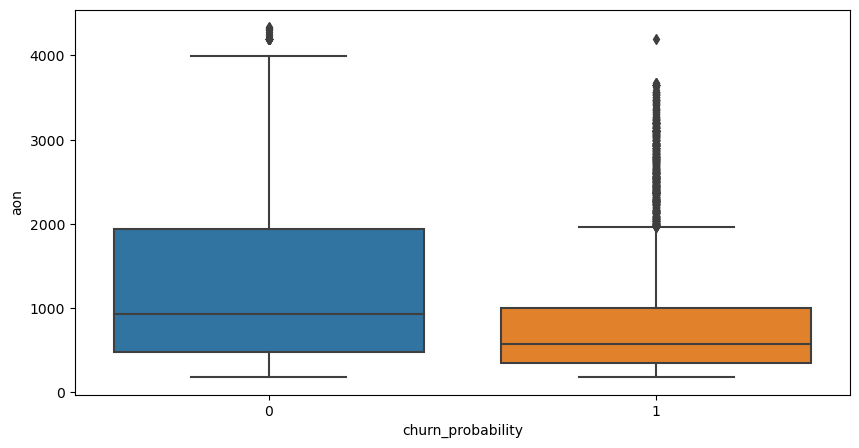

In [69]:
plt.figure(figsize = (10, 5))
#plt.subplot(2,1,1)
sns.boxplot(x = 'churn_probability', y = 'aon', data = teleTrain)

- AON ->Age on network  number of days the customer is using the operator T network
- Customer with lower AON is mostlikely to churn compared to the customer with higher EON

#### arpu - Average revenue per user

<AxesSubplot:xlabel='churn_probability', ylabel='arpu_8'>

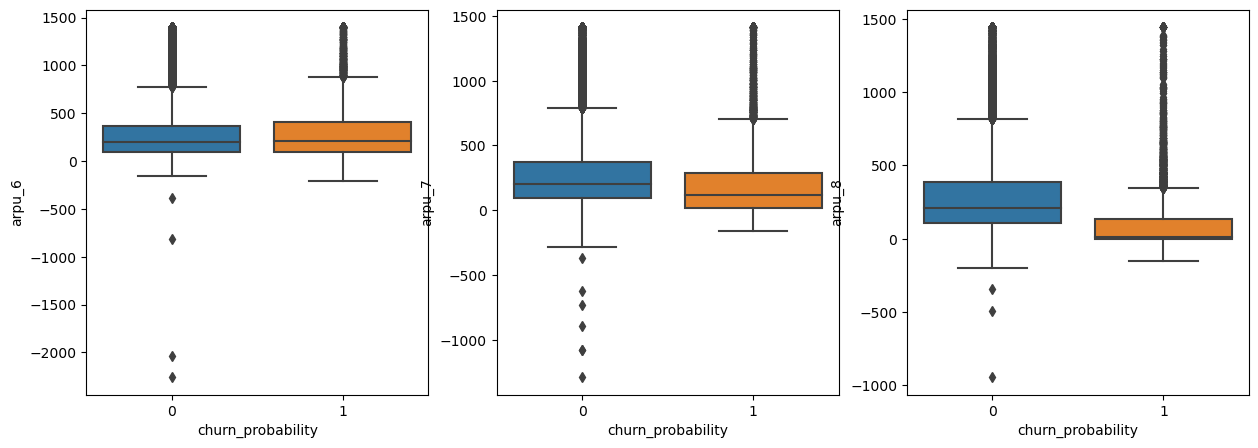

In [70]:
# Joint study of mnth and weathersit on Demand
plt.figure(figsize = (15, 5))
plt.subplot(1,3,1)
sns.boxplot(x = 'churn_probability', y = 'arpu_6', data = teleTrain)
plt.subplot(1,3,2)
sns.boxplot(x = 'churn_probability', y = 'arpu_7', data = teleTrain)
plt.subplot(1,3,3)
sns.boxplot(x = 'churn_probability', y = 'arpu_8', data = teleTrain)

- arpu - Average revenue per user for the Chuning customer seems to be reducing month on month. 
- We can see that arpu in 6th month for the churning user is same as that of non-churning user
- arpu for the churning user is lesser comppared to non-churn user for 7 and 8th month

####  Analysis on the various incoming  and outgoing service features
    - loc_ic_mou - Overall Minutes of usage of a customer for incoming calls in the same telecom circle
    - loc_og_mou - Overall Minutes of usage of a customer for outgoing calls in the same telecom circle
    - roam_ic_mou/roam_og_mou - Incoming and Outgoing Minutes for Roaming services
    - total_ic_mou/total_og_mou - Incoming and Outgoing Minutes for Total services
    - isd_ic_mou/isd_og_mou/std_ic_mou/std_og_mou/ - Std and ISD incoming and outgoing call usage
    

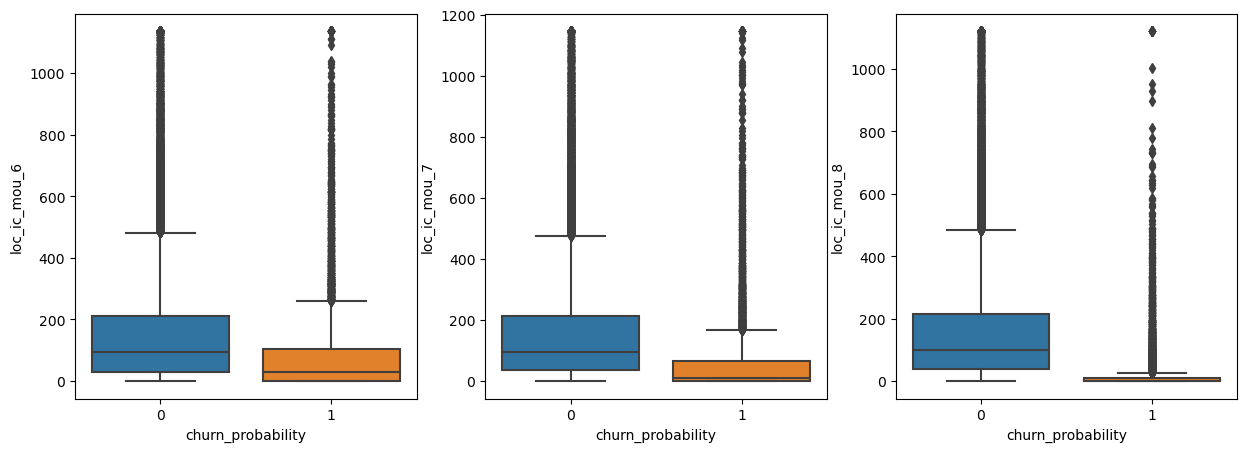

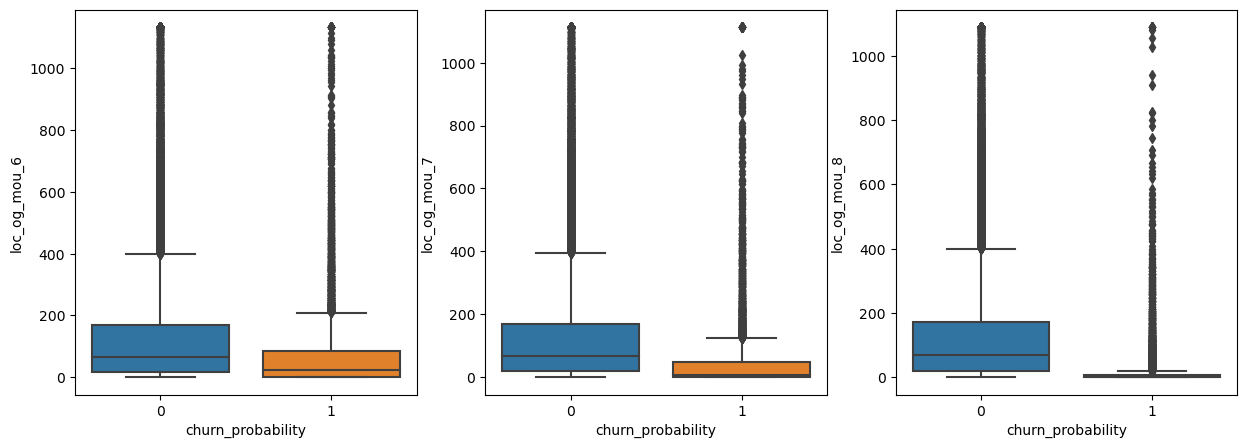

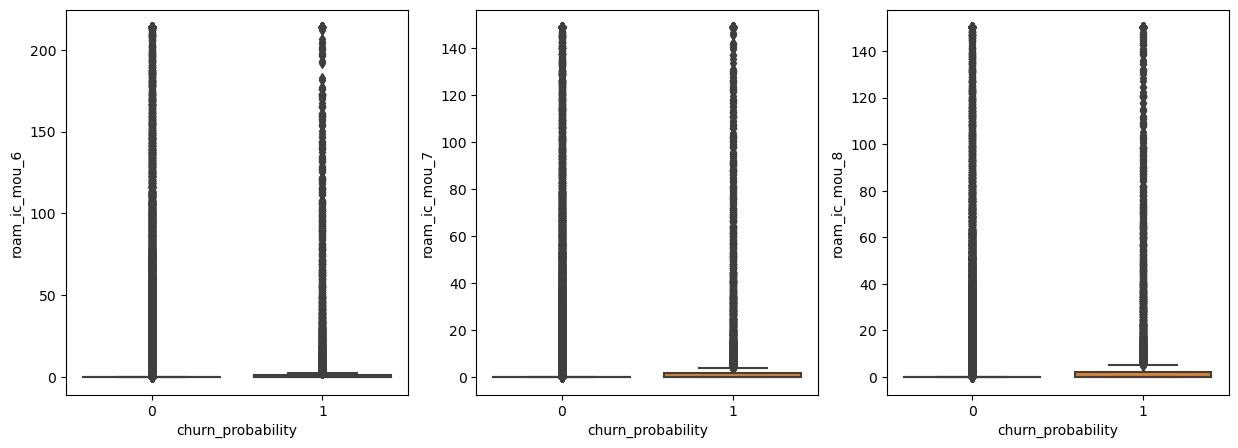

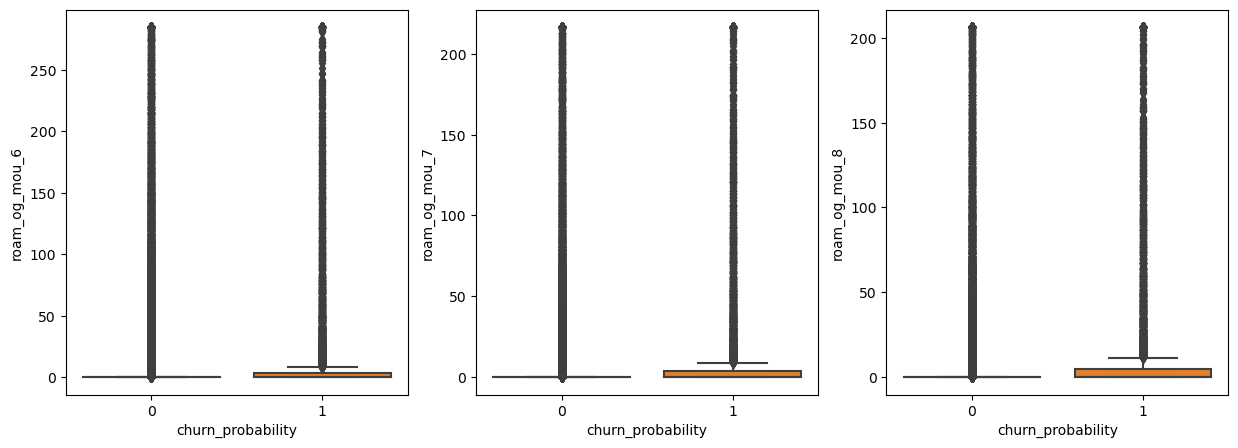

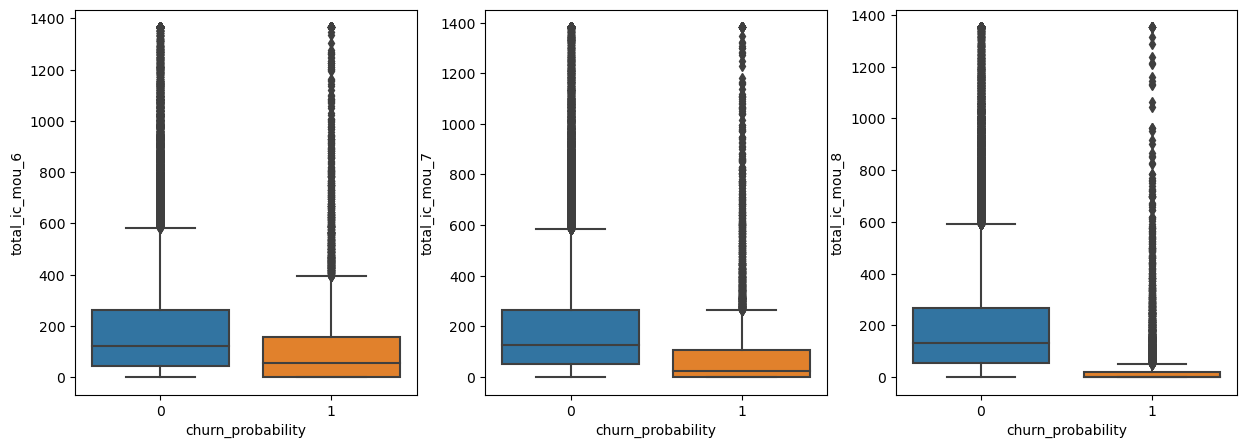

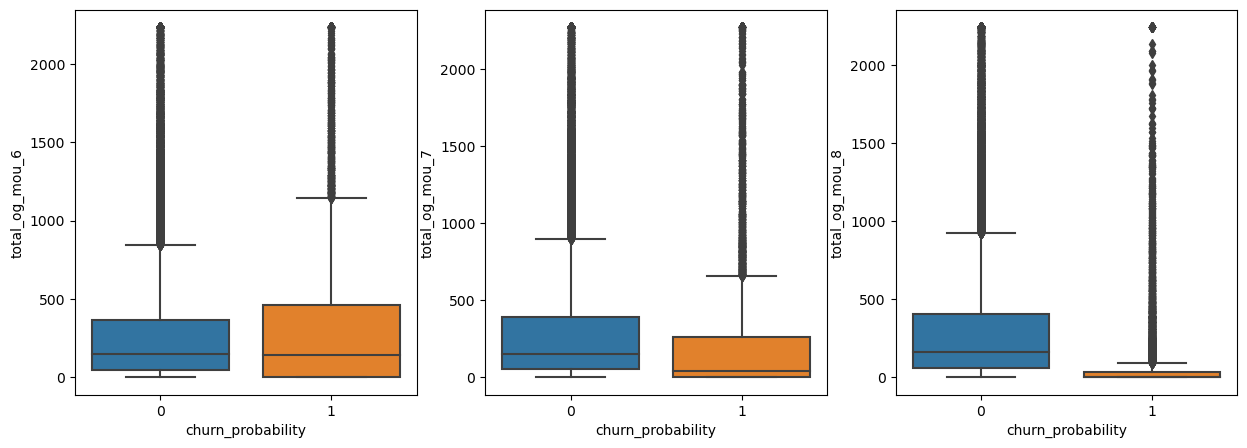

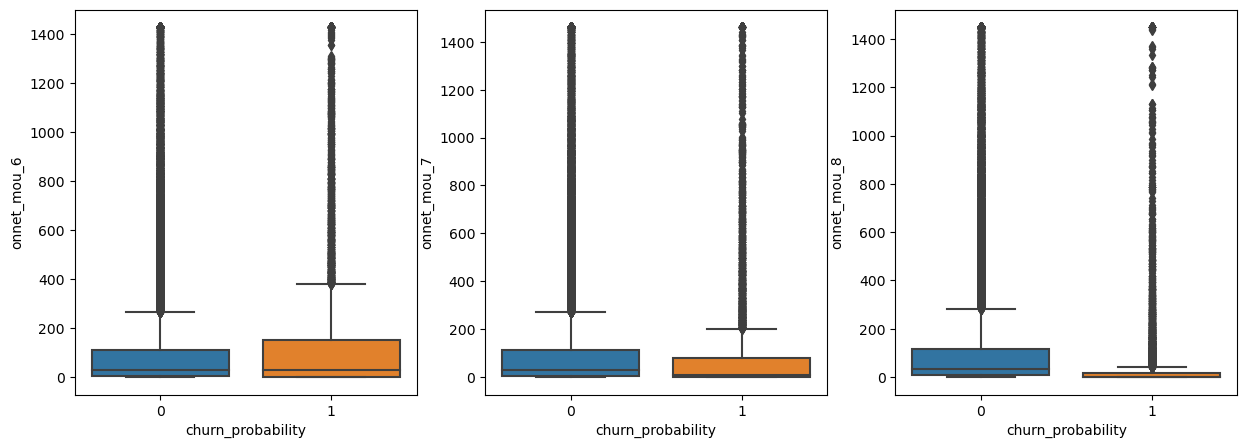

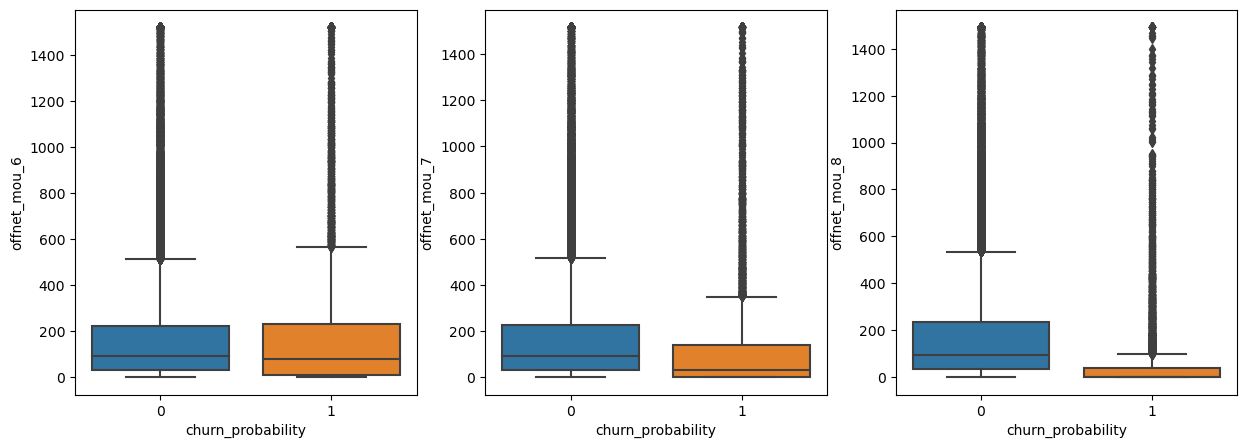

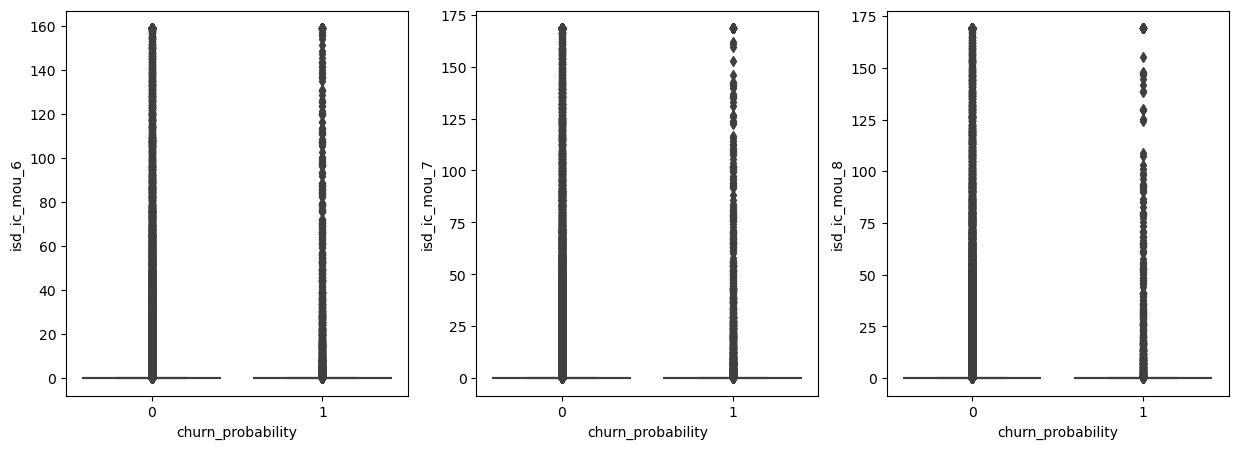

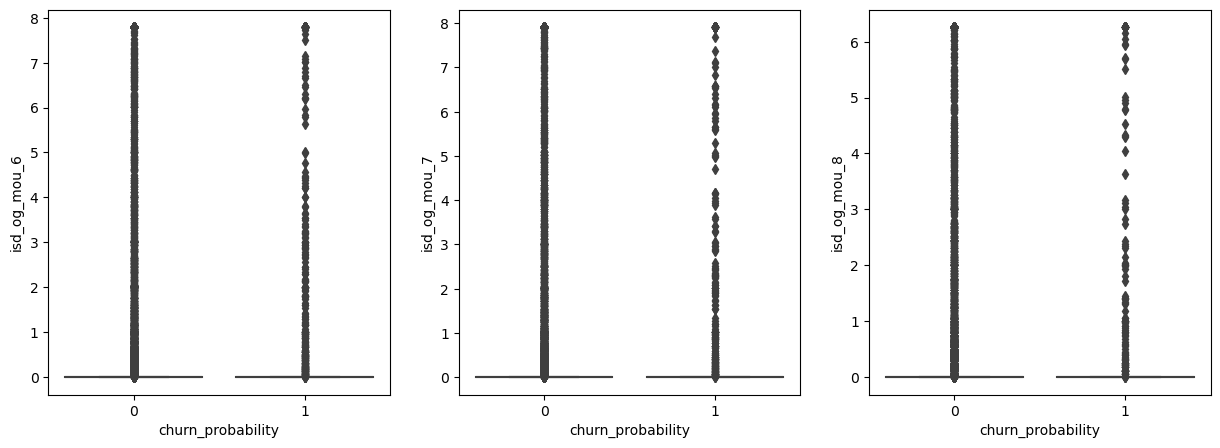

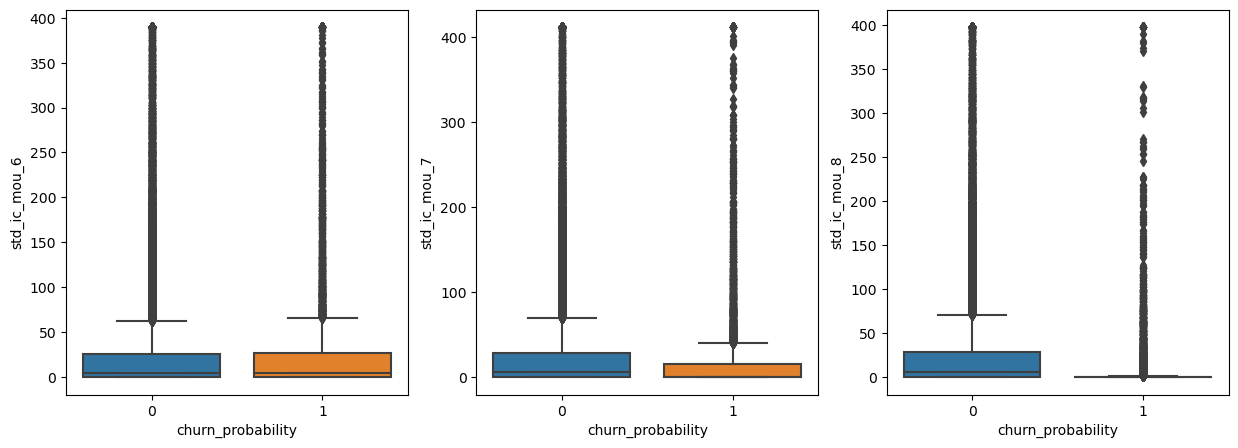

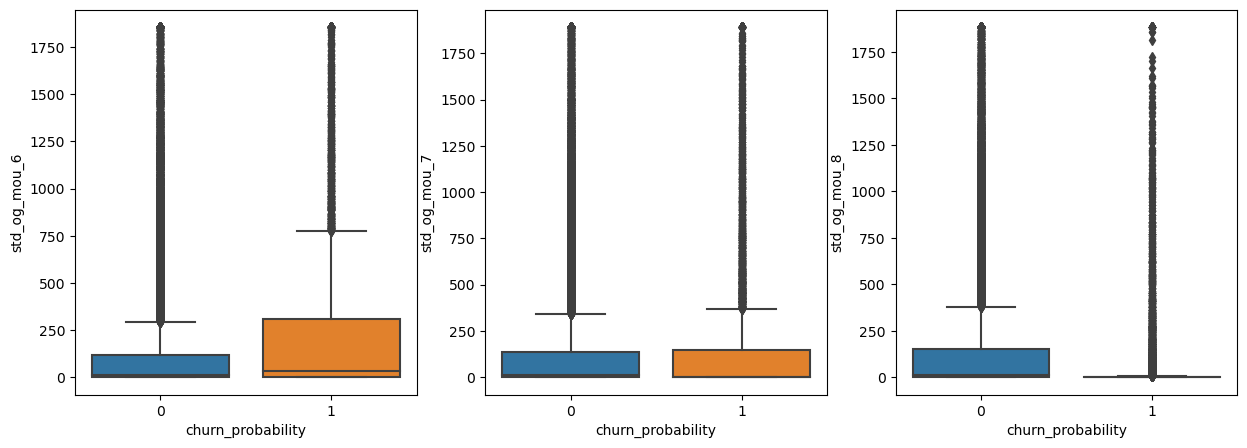

In [71]:
def bxplt(feat,chrn,df):
    mnt = ['_6','_7','_8'];
    col = list(map(lambda x: "".join([feat,x]),mnt))
    plt.figure(figsize = (15, 5))
    plt.subplot(1,3,1)
    sns.boxplot(x = chrn, y = col[0], data = df)
    plt.subplot(1,3,2)
    sns.boxplot(x = chrn, y = col[1], data = df)
    plt.subplot(1,3,3)
    sns.boxplot(x = chrn, y = col[2], data = df)

bxplt('loc_ic_mou','churn_probability',teleTrain)
bxplt('loc_og_mou','churn_probability',teleTrain)
bxplt('roam_ic_mou','churn_probability',teleTrain)
bxplt('roam_og_mou','churn_probability',teleTrain)
bxplt('total_ic_mou','churn_probability',teleTrain)
bxplt('total_og_mou','churn_probability',teleTrain)
bxplt('onnet_mou','churn_probability',teleTrain)
bxplt('offnet_mou','churn_probability',teleTrain)
bxplt('isd_ic_mou','churn_probability',teleTrain)
bxplt('isd_og_mou','churn_probability',teleTrain)
bxplt('std_ic_mou','churn_probability',teleTrain)
bxplt('std_og_mou','churn_probability',teleTrain)

- loc_ic_mou & loc_og_mou also seems to reduce month on month for the Churning user's 
- roam_og_* and roam_ic_* churning users seems to increase every month. Possibly the churning users are heavy roaming users and either the quality or cost may be making them to churn. Non-churn users dont seem to use roaming heavily.
- Total incoming and outcoming call usage of churning user seems to be reducing month on month.
- isd  usage is less and dont seem to impact the churning 
- std usage of churning customer is more than non-churn for 6th month and seem to reduce on a monthly basis


#### Analysis of 3G and 2G Services

In [72]:
def cntplt(col,chrn,df):
    plt.figure(figsize = (12, 3))
    plt.subplot(1,3,1)
    sns.countplot(x=col[0],hue=chrn,data=df)
    plt.subplot(1,3,2)
    sns.countplot(x=col[1],hue=chrn,data=df)
    plt.subplot(1,3,3)
    sns.countplot(x=col[2],hue=chrn,data=df)

enableHighPrcPlot = 0

if enableHighPrcPlot:    
    col = ['monthly_3g_6','monthly_3g_7','monthly_3g_8']
    cntplt(col,'churn_probability',teleTrain)    
    col = ['monthly_2g_6','monthly_2g_7','monthly_2g_8']
    cntplt(col,'churn_probability',teleTrain)    
    col = ['sachet_3g_6','sachet_3g_7','sachet_3g_8']
    cntplt(col,'churn_probability',teleTrain)    
    col = ['sachet_2g_6','sachet_2g_7','sachet_2g_8']
    cntplt(col,'churn_probability',teleTrain)
    col = ['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']
    cntplt(col,'churn_probability',teleTrain)

#### Analysis of Correlation of Numeric Variables

In [73]:
enableHighPrcPlot = 0
if enableHighPrcPlot :
    plt.figure(figsize = (40, 20))
    sns.heatmap(teleTrain[teleTrain.select_dtypes(['float64','int64']).columns ].corr().round(1).abs(), annot = True, cmap="RdYlGn")


In [74]:
## Flitered Correlation plot Function based on Threshold
def plt_filtered_Corr(df,thr):
    dfCorr =df.corr()
    filteredDf = dfCorr[((dfCorr.abs() >= thr)  & (dfCorr !=1.000))]
    plt.figure(figsize=(65,20))
    sns.heatmap(filteredDf.round(1), annot=True, cmap="Reds")
    plt.show()
    return filteredDf
## Getting Collinear Variables.
def get_collinear_pair(Correl):
    df=Correl.dropna(how = 'all').unstack()
    collinear_pair = list()
    corrVal = list()
    for i in df.index:
          if(np.isfinite(df[i])):
                j = list(i)
                collinear_pair.extend(j)
                corrVal.extend([j,df[i].round(2)])
    return collinear_pair,corrVal 

enableHighPrcPlot = 0
if enableHighPrcPlot :
    collThr = 0.65;  ## Collunear threshold for elimination
    Num_Columns  =teleTrain[teleTrain.select_dtypes(['float64','int64']).columns]   
    plt.figure(figsize = (6, 8))
    teleTrain_indep = teleTrain.drop(columns = ['id'])
    NewCol  = teleTrain_indep.select_dtypes(['float64','int64']).columns    
    filterCorr = plt_filtered_Corr(teleTrain_indep[NewCol],collThr)
    collinear_pair,corrVal = get_collinear_pair(filterCorr)
    collinear_pair

- arpu_6,7,8 seems to be collinear to total_recj_amt_6,7,8
- 


##  <a id="3"> Model Building </a>


[Back to TOC](#0)


### Strategy

- Test Train Split
- Class Imbalance (SMOTE)
- Standardization
- Modelling
    - Logistic Regression with RFE & Manual Elimination ( Interpretable Model )
    - PCA + Logistic Regression
    - PCA + Random Forest Classifier
    - PCA + XGBoost

###  <a id="3.1"> Data Preparation for Model Building </a>

In [75]:
y = teleTrain.pop('churn_probability') # Predicted / Target Variable
X = teleTrain # Predictor variables

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=42)

- Proivided test-set call it validation set

In [77]:
y_test_val = teleTest.pop('churn_probability') # Predicted / Target Variable
X_test_val = teleTest # Predictor variables

#### Use SMOTE to account for Class Imbalance


In [78]:
#!pip install imblearn
from imblearn.over_sampling import SMOTE
print(y.value_counts(normalize=True).to_frame())
# Ratio of classes 
print(f'Class Imbalance Ratio : {round( y[y == 1].count()/ y[y == 0].count(),3)}')
## Use SMOTE Class
smt = SMOTE(random_state=28, k_neighbors=5)
# Resampling Train set to account for class imbalance
X_train_resampled, y_train_resampled= smt.fit_resample(X_train, y_train)
X_train_resampled.head()

   churn_probability
0           0.898113
1           0.101887
Class Imbalance Ratio : 0.113


,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,sachet_2g_7_32,sachet_2g_7_35,sachet_2g_7_4,sachet_2g_7_42,sachet_2g_7_48,sachet_2g_7_5,sachet_2g_7_6,sachet_2g_7_7,sachet_2g_7_8,sachet_2g_7_9
0,61787,373.161,468.636,679.900,60.03,98.26,62.64,658.93,970.49,1197.26,...,0,0,0,0,0,0,0,0,0,0
1,19961,81.812,88.382,55.468,0.00,0.00,0.00,0.00,0.28,0.46,...,0,0,0,0,0,0,0,0,1,0
2,11040,366.437,264.586,247.665,47.66,34.06,115.89,203.21,299.94,273.94,...,0,0,0,0,0,0,0,0,0,0
3,27673,328.054,53.221,42.170,368.18,43.73,10.70,173.51,19.64,0.00,...,0,0,0,0,0,0,0,0,0,0
4,22876,59.990,66.337,75.979,8.59,31.08,34.46,48.76,34.78,75.64,...,0,0,0,0,0,0,0,0,0,0


#### Standardization

In [79]:
# Standard scaling
from sklearn.preprocessing import StandardScaler

# columns with numerical data
condition1 = teleTrain.dtypes == 'int'
condition2 = teleTrain.dtypes == 'float'
numerical_col = teleTrain.columns[condition1 | condition2].to_list()

scaler = StandardScaler() 

# Fit and transform train set 
X_train[numerical_col] = scaler.fit_transform(X_train[numerical_col])

# Transform test set
X_test[numerical_col] = scaler.transform(X_test[numerical_col])

# Transforming test_validation set
X_test_val[numerical_col] = scaler.transform(X_test_val[numerical_col])



###  <a id="3.2 ">Modeling </a>


### Model 1 :  Logistic Regression ( Interpretable)

- Build a Logistic Regression Model as a baseline model


In [80]:
from sklearn.linear_model import LogisticRegression


baseline_model = LogisticRegression(random_state=100, class_weight='balanced') # `weight of class` balancing technique used
baseline_model = baseline_model.fit(X_train, y_train)

y_train_pred = baseline_model.predict_proba(X_train)[:,1]
y_test_pred  = baseline_model.predict_proba(X_test)[:,1]
y_test_val_pred  = baseline_model.predict_proba(X_test_val)[:,1]


In [81]:
y_train_pred = pd.Series(y_train_pred,index = X_train.index, ) # converting test and train to a series to preserve index
y_test_pred = pd.Series(y_test_pred,index = X_test.index)
y_test_val_pred = pd.Series(y_test_val_pred,index = X_test_val.index)

### Performance 

In [82]:
###Performance Matrix
import math
def model_metrics(matrix) :
    TN = matrix[0][0]
    TP = matrix[1][1]
    FP = matrix[0][1]
    FN = matrix[1][0]
    accuracy = round((TP + TN)/float(TP+TN+FP+FN),3)
    print('Accuracy :' ,accuracy )
    sensitivity = round(TP/float(FN + TP),3)
    print('Sensitivity / True Positive Rate / Recall :', sensitivity)
    specificity = round(TN/float(TN + FP),3)
    print('Specificity / True Negative Rate : ', specificity)
    precision = round(TP/float(TP + FP),3)
    print('Precision / Positive Predictive Value :', precision)
    print('F1-score :', round(2*precision*sensitivity/(precision + sensitivity),3))

In [83]:
# Prediction at threshold of 0.5 
classification_threshold = 0.5 
    
y_train_pred_classified = y_train_pred.map(lambda x : 1 if x > classification_threshold else 0)
y_test_pred_classified = y_test_pred.map(lambda x : 1 if x > classification_threshold else 0)
y_test_val_pred_classified = y_test_val_pred.map(lambda x : 1 if x > classification_threshold else 0)

In [84]:
from sklearn.metrics import confusion_matrix
train_matrix = confusion_matrix(y_train, y_train_pred_classified)
print('Confusion Matrix for train:\n', train_matrix)
test_matrix = confusion_matrix(y_test, y_test_pred_classified)
print('\nConfusion Matrix for test: \n', test_matrix)

test_matrix_val = confusion_matrix(y_test_val, y_test_val_pred_classified)
print('\nConfusion Matrix for test val: \n', test_matrix_val)


Confusion Matrix for train:
 [[35746  8276]
 [  666  4311]]

Confusion Matrix for test: 
 [[15275  3570]
 [  283  1872]]

Confusion Matrix for test val: 
 [[21538  5403]
 [  424  2635]]


In [85]:
# Baseline Model Performance : 

print('Train Performance : \n')
model_metrics(train_matrix)

print('\n\nTest Performance : \n')
model_metrics(test_matrix)

print('\n\nTest Performance for Validation : \n')
model_metrics(test_matrix_val)

Train Performance : 

Accuracy : 0.818
Sensitivity / True Positive Rate / Recall : 0.866
Specificity / True Negative Rate :  0.812
Precision / Positive Predictive Value : 0.342
F1-score : 0.49


Test Performance : 

Accuracy : 0.817
Sensitivity / True Positive Rate / Recall : 0.869
Specificity / True Negative Rate :  0.811
Precision / Positive Predictive Value : 0.344
F1-score : 0.493


Test Performance for Validation : 

Accuracy : 0.806
Sensitivity / True Positive Rate / Recall : 0.861
Specificity / True Negative Rate :  0.799
Precision / Positive Predictive Value : 0.328
F1-score : 0.475


- Find the optimal cutoff

### Baseline Performance - Finding Optimum Probability Cutoff



In [86]:
# Specificity / Sensitivity Tradeoff 

# Classification at probability thresholds between 0 and 1 
y_train_pred_thres = pd.DataFrame(index=X_train.index)
thresholds = [float(x)/10 for x in range(10)]

def thresholder(x, thresh) :
    if x > thresh : 
        return 1 
    else : 
        return 0

    
for i in thresholds:
    y_train_pred_thres[i]= y_train_pred.map(lambda x : thresholder(x,i))
y_train_pred_thres.head()

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
61787,1,1,1,0,0,0,0,0,0,0
19961,1,0,0,0,0,0,0,0,0,0
11040,1,0,0,0,0,0,0,0,0,0
27673,1,1,1,1,1,1,1,1,0,0
22876,1,0,0,0,0,0,0,0,0,0


In [87]:
# # sensitivity, specificity, accuracy for each threshold
metrics_df = pd.DataFrame(columns=['sensitivity', 'specificity', 'accuracy'])

# Function for calculation of metrics for each threshold
def model_metrics_thres(matrix) :
    TN = matrix[0][0]
    TP = matrix[1][1]
    FP = matrix[0][1]
    FN = matrix[1][0]
    accuracy = round((TP + TN)/float(TP+TN+FP+FN),3)
    sensitivity = round(TP/float(FN + TP),3)
    specificity = round(TN/float(TN + FP),3)
    return sensitivity,specificity,accuracy

# generating a data frame for metrics for each threshold
for thres,column in zip(thresholds,y_train_pred_thres.columns.to_list()) : 
    confusion = confusion_matrix(y_train, y_train_pred_thres.loc[:,column])
    sensitivity,specificity,accuracy = model_metrics_thres(confusion)
    
    metrics_df =  metrics_df.append({ 
        'sensitivity' :sensitivity,
        'specificity' : specificity,
        'accuracy' : accuracy
    }, ignore_index = True)
    
metrics_df.index = thresholds
metrics_df

,sensitivity,specificity,accuracy
0.0,1.000,0.000,0.102
0.1,0.973,0.415,0.472
0.2,0.951,0.560,0.600
0.3,0.929,0.662,0.689
0.4,0.900,0.744,0.760
0.5,0.866,0.812,0.818
0.6,0.817,0.867,0.862
0.7,0.740,0.913,0.896
0.8,0.581,0.952,0.914
0.9,0.243,0.984,0.908


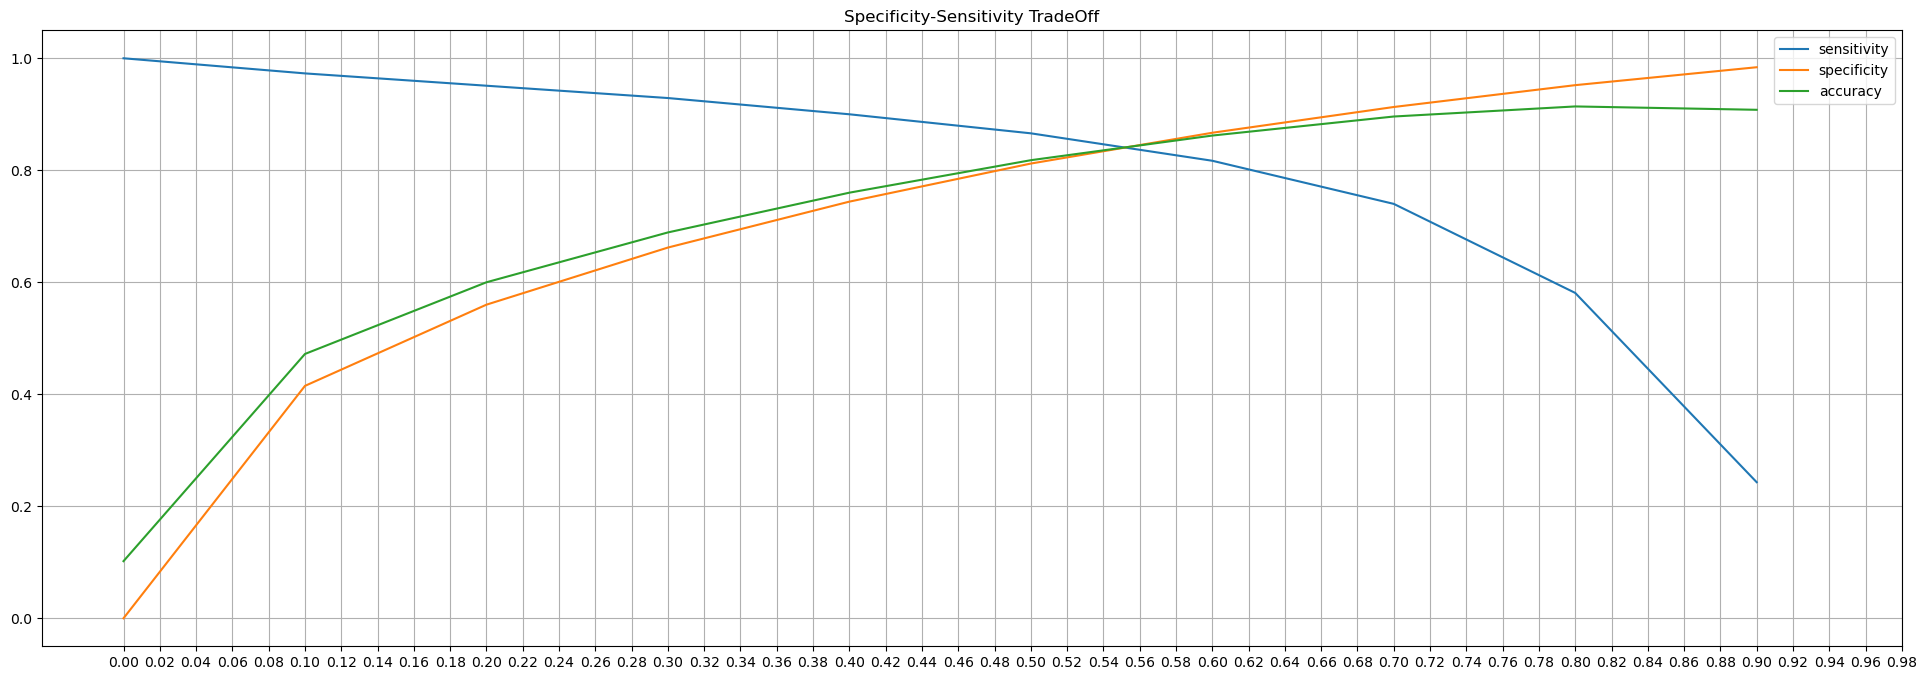

In [88]:
metrics_df.plot(kind='line', figsize=(24,8), grid=True, xticks=np.arange(0,1,0.02),
                title='Specificity-Sensitivity TradeOff');

In [89]:
optimum_cutoff = 0.51
y_train_pred_final = y_train_pred.map(lambda x : 1 if x > optimum_cutoff else 0)
y_test_pred_final = y_test_pred.map(lambda x : 1 if x > optimum_cutoff else 0)

train_matrix = confusion_matrix(y_train, y_train_pred_final)
print('Confusion Matrix for train:\n', train_matrix)
test_matrix = confusion_matrix(y_test, y_test_pred_final)
print('\nConfusion Matrix for test: \n', test_matrix)

Confusion Matrix for train:
 [[36021  8001]
 [  685  4292]]

Confusion Matrix for test: 
 [[15379  3466]
 [  288  1867]]


In [90]:
print('Train Performance: \n')
model_metrics(train_matrix)

print('\n\nTest Performance : \n')
model_metrics(test_matrix)

Train Performance: 

Accuracy : 0.823
Sensitivity / True Positive Rate / Recall : 0.862
Specificity / True Negative Rate :  0.818
Precision / Positive Predictive Value : 0.349
F1-score : 0.497


Test Performance : 

Accuracy : 0.821
Sensitivity / True Positive Rate / Recall : 0.866
Specificity / True Negative Rate :  0.816
Precision / Positive Predictive Value : 0.35
F1-score : 0.499


In [91]:
y_test_val_pred_final = y_test_val_pred.map(lambda x : 1 if x > optimum_cutoff else 0)
test_matrix_val = confusion_matrix(y_test_val, y_test_val_pred_final)
print('\n\nTest Performance : \n')
model_metrics(test_matrix_val)



Test Performance : 

Accuracy : 0.811
Sensitivity / True Positive Rate / Recall : 0.858
Specificity / True Negative Rate :  0.805
Precision / Positive Predictive Value : 0.334
F1-score : 0.481


In [92]:
# ROC_AUC score 
from sklearn.metrics import roc_auc_score
print('ROC AUC score for Train : ',round(roc_auc_score(y_train, y_train_pred),3), '\n' )
print('ROC AUC score for Test : ',round(roc_auc_score(y_test, y_test_pred),3) )
print('ROC AUC score for Test_Val: ',round(roc_auc_score(y_test_val, y_test_val_pred_final),3))


ROC AUC score for Train :  0.906 

ROC AUC score for Test :  0.903
ROC AUC score for Test_Val:  0.832


### Feature Selection for RFE

In [93]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42 , class_weight='balanced')
rf_e = RFE(lr,n_features_to_select=15)
results = rf_e.fit(X_train,y_train)
results.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [96]:
# DataFrame with features supported by RFE
rfe_support = pd.DataFrame({'Column' : X.columns.to_list(), 'Rank' : rf_e.ranking_, 
                                      'Support' :  rf_e.support_}).sort_values(by=
                                       'Rank', ascending=True)
rfe_support

,Column,Rank,Support
313,sachet_3g_8_2,1,True
392,sachet_2g_8_8,1,True
391,sachet_2g_8_7,1,True
352,sachet_2g_6_34,1,True
362,sachet_2g_8_10,1,True
...,...,...,...
243,monthly_3g_7_16,410,False
295,sachet_3g_7_35,411,False
322,sachet_3g_8_38,412,False
50,og_others_7,413,False


In [97]:
# RFE Selected columns
rfe_selected_columns = rfe_support.loc[rfe_support['Rank'] == 1,'Column'].to_list()
rfe_selected_columns

['sachet_3g_8_2',
 'sachet_2g_8_8',
 'sachet_2g_8_7',
 'sachet_2g_6_34',
 'sachet_2g_8_10',
 'sachet_2g_8_5',
 'loc_ic_mou_8',
 'monthly_3g_7_4',
 'sachet_2g_8_11',
 'sachet_2g_8_13',
 'sachet_2g_8_20',
 'date_of_last_rech_8_cat_d30',
 'sachet_2g_8_14',
 'sachet_3g_8_8',
 'sachet_2g_8_9']